##### Section 4.1: Master Dark and Flat Corrections

In [1]:
# Importing necessary libraries 
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
import matplotlib.pyplot as plt
import os
import astropy
import keyring
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats
from photutils.segmentation import SourceCatalog, detect_sources
from astropy.convolution import convolve, Gaussian2DKernel

C:\Users\misha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Setting up astronomy.net 
astropy.__path__
keyring.set_password('astroquery:astrometry_net', 'mishasonmez', '')
ast = AstrometryNet()
ast.api_key = ''
# Set timeout to 5 minutes (300 seconds)
ast.TIMEOUT = 300

In [3]:
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    for i in range(start_idx, end_idx + 1):
        file_path = file_template.format(i)  # Create file path from template and index
        with fits.open(file_path) as hdul:
            header = hdul[0].header  # Extract header
            data = hdul[0].data  # Extract image data
            frames_info.append((header, data))  # Append header and data as a tuple
    return frames_info  # Return list of header and data tuples

In [4]:
def read_calibration_fits(bias_template, bias_start, bias_end, 
                          dark_light_template, dark_light_start, dark_light_end, 
                          dark_flat_template, dark_flat_start, dark_flat_end, 
                          light_template, light_start, light_end, 
                          flat_template, flat_start, flat_end):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and light frames.

    :param bias_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_template: str
    :param bias_start: Starting index for the bias frames.
    :type bias_start: int
    :param bias_end: Ending index for the bias frames.
    :type bias_end: int
    :param dark_light_template: Template path for the dark frames used for light frames.
    :type dark_light_template: str
    :param dark_light_start: Starting index for the dark frames used for light frames.
    :type dark_light_start: int
    :param dark_light_end: Ending index for the dark frames used for light frames.
    :type dark_light_end: int
    :param dark_flat_template: Template path for the dark frames used for flat fields.
    :type dark_flat_template: str
    :param dark_flat_start: Starting index for the dark frames used for flat fields.
    :type dark_flat_start: int
    :param dark_flat_end: Ending index for the dark frames used for flat fields.
    :type dark_flat_end: int
    :param light_template: Template path for the light frames.
    :type light_template: str
    :param light_start: Starting index for the light frames.
    :type light_start: int
    :param light_end: Ending index for the light frames.
    :type light_end: int
    :param flat_template: Template path for the flat field frames.
    :type flat_template: str
    :param flat_start: Starting index for the flat field frames.
    :type flat_start: int
    :param flat_end: Ending index for the flat field frames.
    :type flat_end: int
    :return: A tuple containing lists of headers and data for bias, dark-light, dark-flat, light, and flat frames.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_template, bias_start, bias_end)
    dark_light_frames = read_fits_range(dark_light_template, dark_light_start, dark_light_end)
    dark_flat_frames = read_fits_range(dark_flat_template, dark_flat_start, dark_flat_end)
    light_frames = read_fits_range(light_template, light_start, light_end)
    flat_frames = read_fits_range(flat_template, flat_start, flat_end)

    return bias_frames, dark_light_frames, dark_flat_frames, light_frames, flat_frames

# Define the file templates for each calibration frame type for DY_Peg
dy_peg_bias_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Bias_Frames_.{:08d}.BIAS.FIT"
dy_peg_dark_frame_light_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_.{:08d}.DARK.FIT"
dy_peg_dark_frame_flat_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
dy_peg_light_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Light_Frames_.{:08d}.FIT"
dy_peg_flat_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Flat_Fields_.{:08d}.FLAT.FIT"

# Define the file templates for each calibration frame type for CY_Aqr
cy_aqr_bias_frame_template = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Bias_Frames_.{:08d}.BIAS.FIT"
cy_aqr_dark_frame_light_template = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Dark_Frames_.{:08d}.DARK.FIT"
cy_aqr_dark_frame_flat_template = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
cy_aqr_light_frame_template = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Light_Frames_.{:08d}.FIT"
cy_aqr_flat_frame_template = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Flat_Fields_.{:08d}.FLAT.FIT"

# Define the file templates for each calibration frame type for XX_Cyg
xx_cyg_bias_frame_template = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Bias_Frames_.{:08d}.BIAS.FIT"
xx_cyg_dark_frame_light_template = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Dark_Frames_.{:08d}.DARK.FIT"
xx_cyg_dark_frame_flat_template = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
xx_cyg_light_frame_template = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Light_Frames_.{:08d}.FIT"
xx_cyg_flat_frame_template = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Flat_Fields_.{:08d}.FLAT.FIT"

# Define the starting and ending indices for each type of frame for DY_Peg
dy_peg_bias_frame_start_index = 0
dy_peg_bias_frame_end_index = 9
dy_peg_dark_frame_light_start_index = 0
dy_peg_dark_frame_light_end_index = 9
dy_peg_dark_frame_flat_start_index = 0
dy_peg_dark_frame_flat_end_index = 9
dy_peg_light_frame_start_index = 0
dy_peg_light_frame_end_index = 240  # Ignore frames 67 to 71, and 122 for further analysis
dy_peg_flat_frame_start_index = 8
dy_peg_flat_frame_end_index = 17

# Define the starting and ending indices for each type of frame for CY_Aqr
cy_aqr_bias_frame_start_index = 0
cy_aqr_bias_frame_end_index = 9
cy_aqr_dark_frame_light_start_index = 19
cy_aqr_dark_frame_light_end_index = 27
cy_aqr_dark_frame_flat_start_index = 9
cy_aqr_dark_frame_flat_end_index = 18
cy_aqr_light_frame_start_index = 0
cy_aqr_light_frame_end_index = 199  # Ignore frames 180 to 200, for further analysis
cy_aqr_flat_frame_start_index = 0
cy_aqr_flat_frame_end_index = 9

# Define the starting and ending indices for each type of frame for XX_Cyg
xx_cyg_bias_frame_start_index = 0
xx_cyg_bias_frame_end_index = 9
xx_cyg_dark_frame_light_start_index = 0
xx_cyg_dark_frame_light_end_index = 9
xx_cyg_dark_frame_flat_start_index = 0
xx_cyg_dark_frame_flat_end_index = 9
xx_cyg_light_frame_start_index = 0
xx_cyg_light_frame_end_index = 349  # Ignore frames 25, 350, and 341 to 350, for further analysis
xx_cyg_flat_frame_start_index = 1
xx_cyg_flat_frame_end_index = 10

# Call the function to read the calibration FITS files for DY_Peg
dy_peg_bias_frames, dy_peg_dark_frame_light, dy_peg_dark_frame_flat, dy_peg_light_frame, dy_peg_flat_frame = read_calibration_fits(
    dy_peg_bias_frame_template, dy_peg_bias_frame_start_index, dy_peg_bias_frame_end_index,
    dy_peg_dark_frame_light_template, dy_peg_dark_frame_light_start_index, dy_peg_dark_frame_light_end_index,
    dy_peg_dark_frame_flat_template, dy_peg_dark_frame_flat_start_index, dy_peg_dark_frame_flat_end_index,
    dy_peg_light_frame_template, dy_peg_light_frame_start_index, dy_peg_light_frame_end_index,
    dy_peg_flat_frame_template, dy_peg_flat_frame_start_index, dy_peg_flat_frame_end_index
)

# Call the function to read the calibration FITS files for CY_Aqr
cy_aqr_bias_frames, cy_aqr_dark_frame_light, cy_aqr_dark_frame_flat, cy_aqr_light_frame, cy_aqr_flat_frame = read_calibration_fits(
    cy_aqr_bias_frame_template, cy_aqr_bias_frame_start_index, cy_aqr_bias_frame_end_index,
    cy_aqr_dark_frame_light_template, cy_aqr_dark_frame_light_start_index, cy_aqr_dark_frame_light_end_index,
    cy_aqr_dark_frame_flat_template, cy_aqr_dark_frame_flat_start_index, cy_aqr_dark_frame_flat_end_index,
    cy_aqr_light_frame_template, cy_aqr_light_frame_start_index, cy_aqr_light_frame_end_index,
    cy_aqr_flat_frame_template, cy_aqr_flat_frame_start_index, cy_aqr_flat_frame_end_index
)

# Call the function to read the calibration FITS files for XX_Cyg
xx_cyg_bias_frames, xx_cyg_dark_frame_light, xx_cyg_dark_frame_flat, xx_cyg_light_frame, xx_cyg_flat_frame = read_calibration_fits(
    xx_cyg_bias_frame_template, xx_cyg_bias_frame_start_index, xx_cyg_bias_frame_end_index,
    xx_cyg_dark_frame_light_template, xx_cyg_dark_frame_light_start_index, xx_cyg_dark_frame_light_end_index,
    xx_cyg_dark_frame_flat_template, xx_cyg_dark_frame_flat_start_index, xx_cyg_dark_frame_flat_end_index,
    xx_cyg_light_frame_template, xx_cyg_light_frame_start_index, xx_cyg_light_frame_end_index,
    xx_cyg_flat_frame_template, xx_cyg_flat_frame_start_index, xx_cyg_flat_frame_end_index
)

In [5]:
def create_master_dark(dark_frame_light_template, dark_frame_flat_template, star_name):
    """
    Create master dark frames for light and flat field frames by median-combining the dark frames.

    :param dark_frame_light_template: List of tuples containing headers and data for light frame darks.
    :type dark_frame_light_template: list of tuples
    :param dark_frame_flat_template: List of tuples containing headers and data for flat field darks.
    :type dark_frame_flat_template: list of tuples
    :param star_name: Name of the star for which the master dark frames are being created.
    :type star_name: str
    :return: Master dark frames for light and flat fields after median combination.
    :rtype: tuple of np.ndarrays
    """
    # Extract data from dark frame templates
    dark_light_data_list = [frame[1] for frame in dark_frame_light_template]
    dark_flat_data_list = [frame[1] for frame in dark_frame_flat_template]
    # Median combine dark frames
    master_dark_l = np.median(np.array(dark_light_data_list), axis=0)
    master_dark_f = np.median(np.array(dark_flat_data_list), axis=0)
    
    # Plot master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title(f'Master Dark Frame for Light Frames ({star_name})')
    plt.grid(False)
    plt.show()

    # Plot master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title(f'Master Dark Frame for Flat Frames ({star_name})')
    plt.grid(False)
    plt.show()

    return master_dark_l, master_dark_f

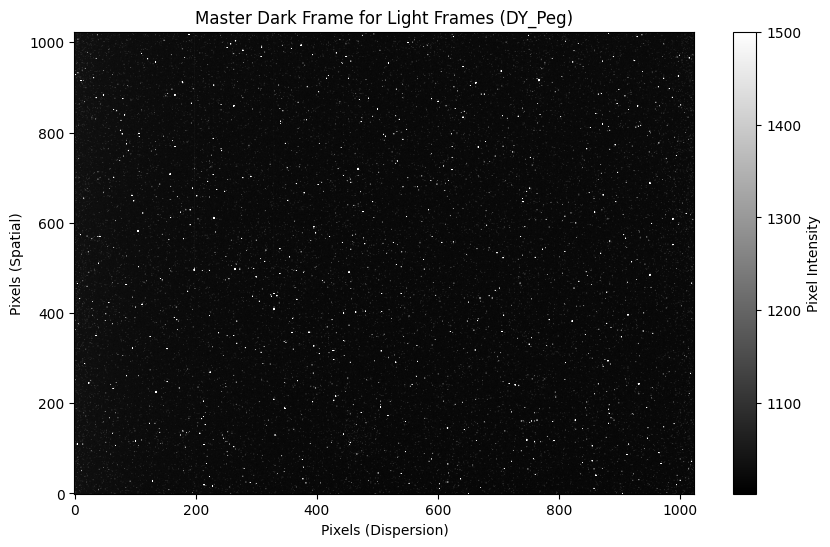

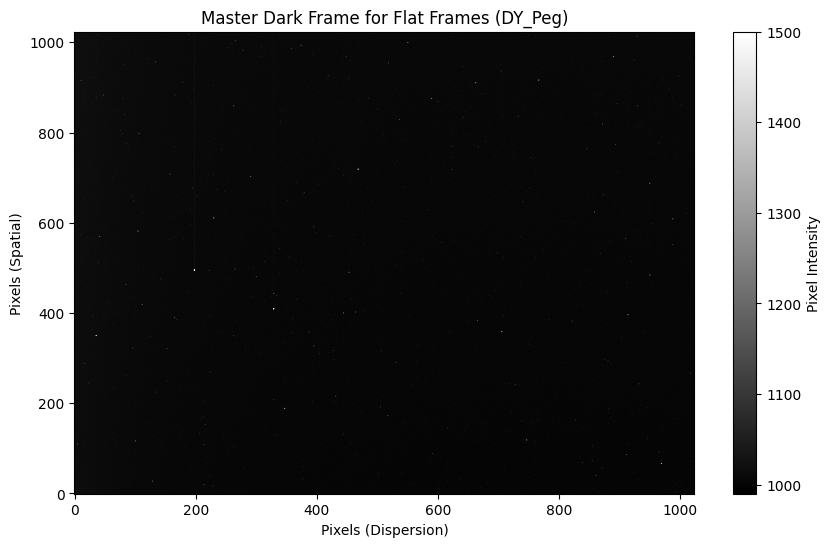

In [6]:
# Read DY_Peg dark frames for light and flat fields
dy_peg_dark_frame_light = read_fits_range(
    dy_peg_dark_frame_light_template, dy_peg_dark_frame_light_start_index, dy_peg_dark_frame_light_end_index
    )
dy_peg_dark_frame_flat = read_fits_range(
    dy_peg_dark_frame_flat_template, dy_peg_dark_frame_flat_start_index, dy_peg_dark_frame_flat_end_index
    )

# Create master dark frames for DY_Peg
dy_peg_master_dark_l, dy_peg_master_dark_f = create_master_dark(
    dy_peg_dark_frame_light, dy_peg_dark_frame_flat, "DY_Peg"
)

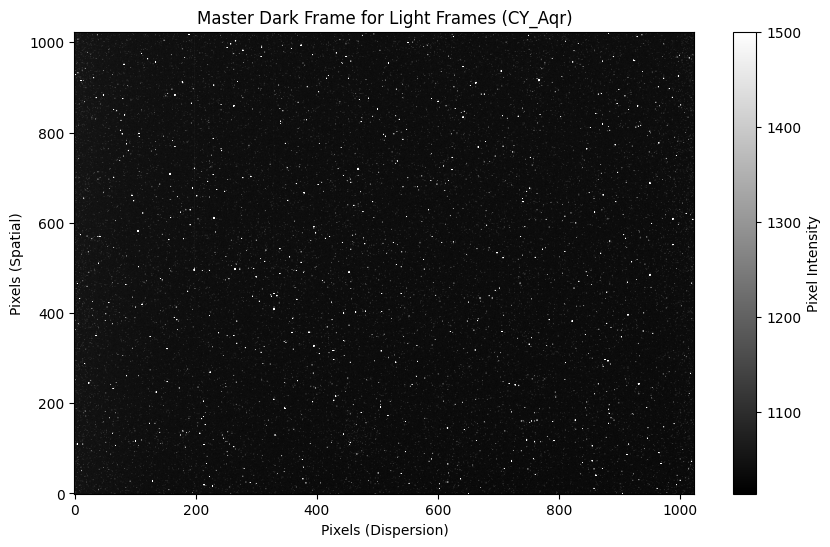

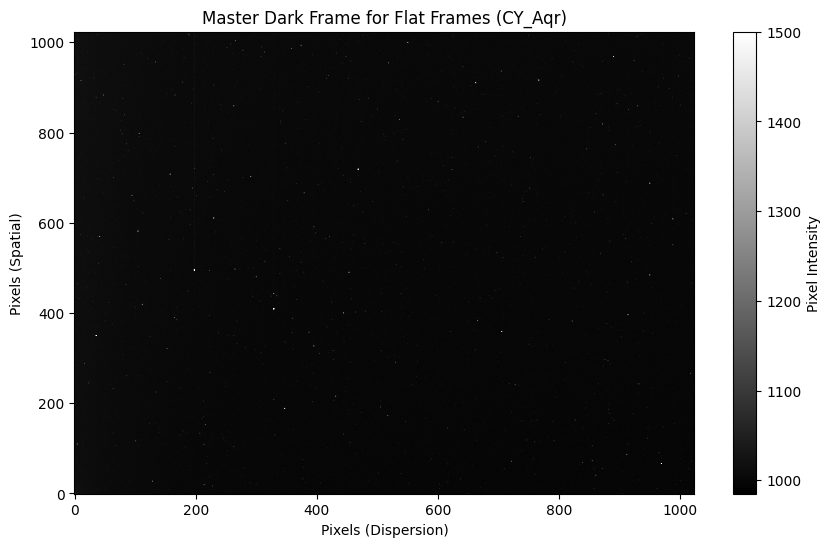

In [7]:
# Read CY_Aqr dark frames for light and flat fields
cy_aqr_dark_frame_light = read_fits_range(
    cy_aqr_dark_frame_light_template, cy_aqr_dark_frame_light_start_index, cy_aqr_dark_frame_light_end_index
    )
cy_aqr_dark_frame_flat = read_fits_range(
    cy_aqr_dark_frame_flat_template, cy_aqr_dark_frame_flat_start_index, cy_aqr_dark_frame_flat_end_index
    )

# Create master dark frames for CY_Aqr
cy_aqr_master_dark_l, cy_aqr_master_dark_f = create_master_dark(
    cy_aqr_dark_frame_light, cy_aqr_dark_frame_flat, "CY_Aqr"
)

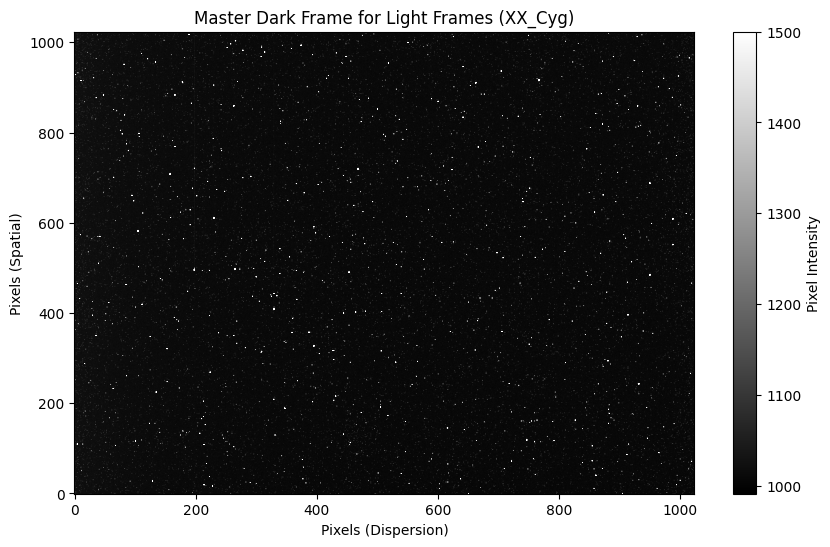

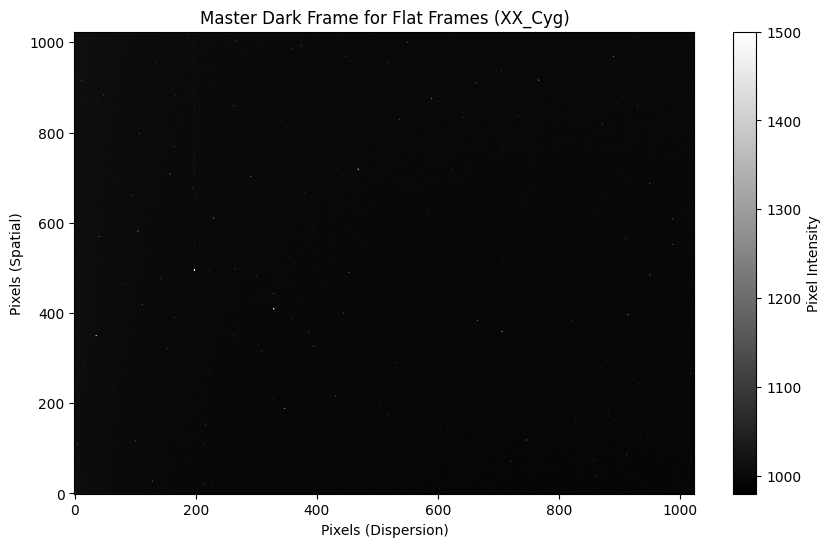

In [8]:
# Read XX_Cyg dark frames for light and flat fields
xx_cyg_dark_frame_light = read_fits_range(
    xx_cyg_dark_frame_light_template, xx_cyg_dark_frame_light_start_index, xx_cyg_dark_frame_light_end_index
    )
xx_cyg_dark_frame_flat = read_fits_range(
    xx_cyg_dark_frame_flat_template, xx_cyg_dark_frame_flat_start_index, xx_cyg_dark_frame_flat_end_index
    )

# Create master dark frames for XX_Cyg
xx_cyg_master_dark_l, xx_cyg_master_dark_f = create_master_dark(
    xx_cyg_dark_frame_light, xx_cyg_dark_frame_flat, "XX_Cyg"
)

In [9]:
def subtract_master_dark(frames, master_dark, frame_name, star_name):
    """
    Subtract the master dark frame from each frame in a list of FITS frames,
    ignoring pixels with negative intensity after subtraction. Visualizes one 
    dark-subtracted light frame.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :param frame_name: Name of the type of frame which dark subtraction is performed.
    :type frame_name: str
    :param star_name: Name of the star for which dark subtraction is performed.
    :type star_name: str
    :return: List of tuples with headers and dark-subtracted data for each frame.
             Pixels with negative intensity are ignored by setting them to zero.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        # Ignore negative pixel values by setting them to zero
        subtracted_data[subtracted_data < 0] = 0
        subtracted_frames.append((header, subtracted_data))

    # Visualize one of the dark-subtracted light frames (e.g., the 5th frame)
    plt.figure(figsize=(10, 6))
    plt.imshow(subtracted_frames[5][1], cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title(f'Dark-Subtracted {frame_name} Frame for {star_name}')
    plt.grid(False)
    plt.show()

    return subtracted_frames

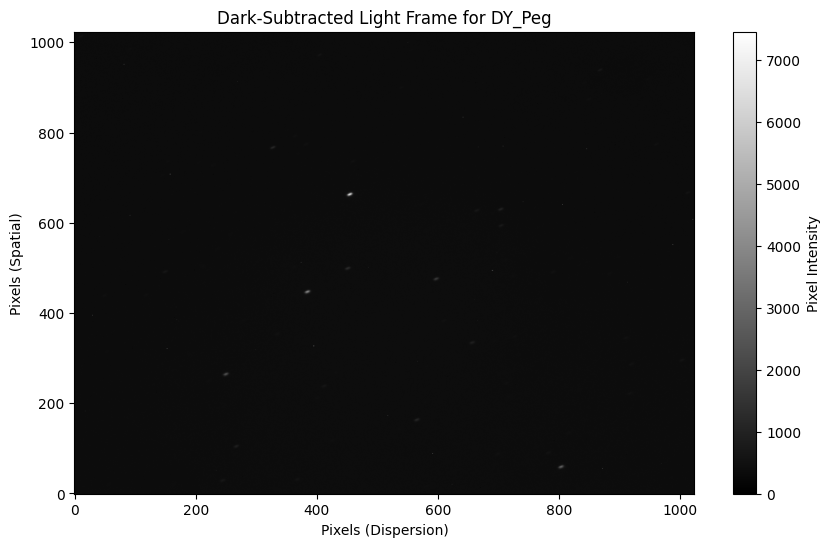

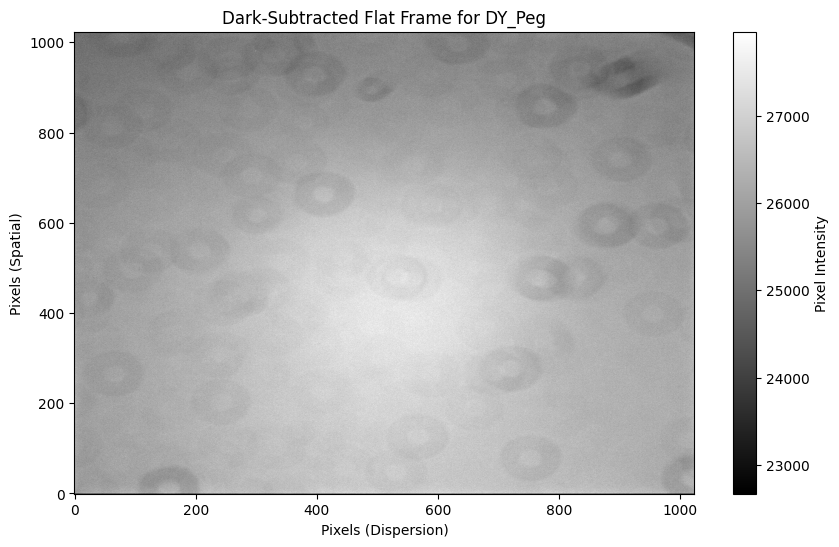

In [10]:
# Load the light and flat frames for DY_Peg
light_frames_dy_peg = read_fits_range(
    dy_peg_light_frame_template, dy_peg_light_frame_start_index, dy_peg_light_frame_end_index
    )

flat_frames_dy_peg = read_fits_range(
    dy_peg_flat_frame_template, dy_peg_flat_frame_start_index, dy_peg_flat_frame_end_index
    )

# Subtracting the master dark frames from DY Peg light and flats 
light_frames_dark_subtracted_dy_peg = subtract_master_dark(
    light_frames_dy_peg, dy_peg_master_dark_l, "Light", "DY_Peg"
)

flat_frames_dark_subtracted_dy_peg = subtract_master_dark(
    flat_frames_dy_peg, dy_peg_master_dark_f, "Flat", "DY_Peg"
)

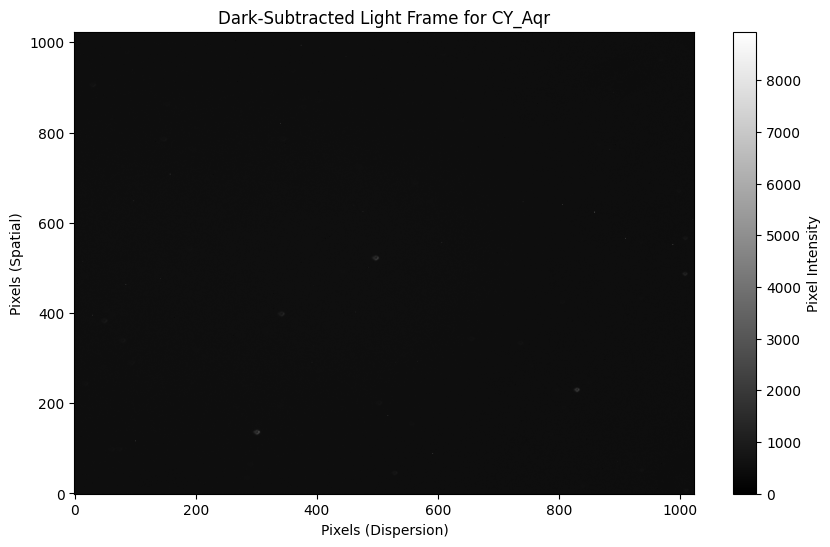

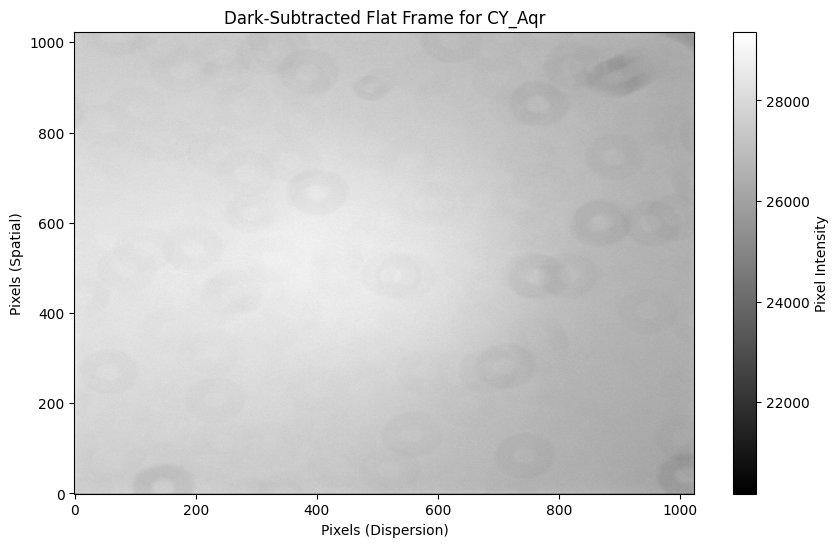

In [11]:
# Load the light and flat frames for CY_Aqr
light_frames_cy_aqr = read_fits_range(
    cy_aqr_light_frame_template, cy_aqr_light_frame_start_index, cy_aqr_light_frame_end_index
    )

flat_frames_cy_aqr = read_fits_range(
    cy_aqr_flat_frame_template, cy_aqr_flat_frame_start_index, cy_aqr_flat_frame_end_index
    )

# Subtracting the master dark frames from CY_Aqr light and flats 
light_frames_dark_subtracted_cy_aqr = subtract_master_dark(
    light_frames_cy_aqr, cy_aqr_master_dark_l, "Light", "CY_Aqr"
)

flat_frames_dark_subtracted_cy_aqr = subtract_master_dark(
    flat_frames_cy_aqr, cy_aqr_master_dark_f, "Flat", "CY_Aqr"
)

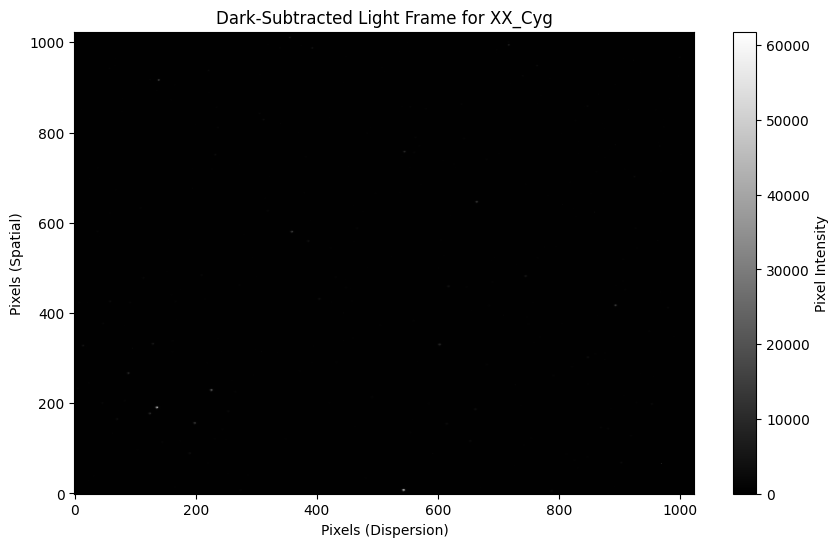

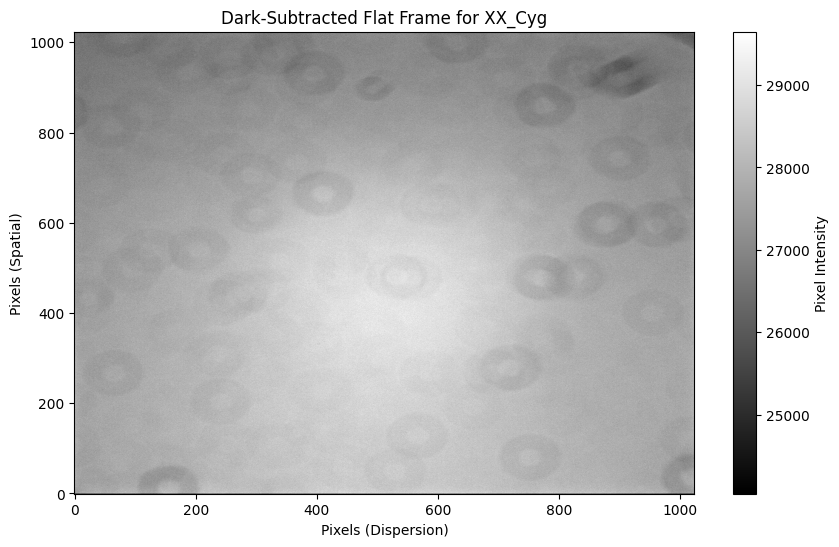

In [12]:
# Load the light and flat frames for XX_Cyg
light_frames_xx_cyg = read_fits_range(
    xx_cyg_light_frame_template, xx_cyg_light_frame_start_index, xx_cyg_light_frame_end_index
    )

flat_frames_xx_cyg = read_fits_range(
    xx_cyg_flat_frame_template, xx_cyg_flat_frame_start_index, xx_cyg_flat_frame_end_index
    )

# Subtracting the master dark frames from XX_Cyg light and flats 
light_frames_dark_subtracted_xx_cyg = subtract_master_dark(
    light_frames_xx_cyg, xx_cyg_master_dark_l, "Light", "XX_Cyg"
)

flat_frames_dark_subtracted_xx_cyg = subtract_master_dark(
    flat_frames_xx_cyg, xx_cyg_master_dark_f, "Flat", "XX_Cyg"
)

In [13]:
def create_normalized_master_flat(flat_frames_dark_subtracted, star_name):
    """
    Create and plot a normalized master flat field for a given star from dark-corrected flat frames.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    :param star_name: Name of the star for which the normalized master flat is created.
    :type star_name: str
    :return: Normalized master flat field as a 2D numpy array.
    :rtype: np.ndarray
    """
    # Combine the dark-corrected flat frames to create a master flat field
    master_flat = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted]), axis=0)
    # Compute the mode value of the master flat field's pixel intensities
    mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]
    # Normalize the master flat field by dividing by the mode value
    normalized_master_flat = master_flat / mode_value

    # Plot the normalized master flat field
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_master_flat, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title(f'Normalized Master Dark-Corrected Flat Field ({star_name})')
    plt.grid(False)
    plt.show()

    return normalized_master_flat

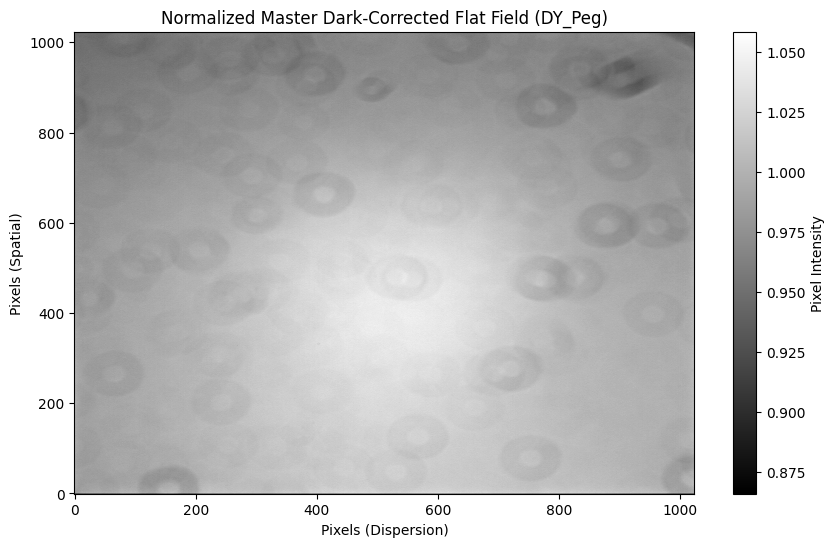

In [14]:
# Make the normalized master flat fields for DY Peg 
normalized_master_flat_DY_Peg = create_normalized_master_flat(flat_frames_dark_subtracted_dy_peg, "DY_Peg")

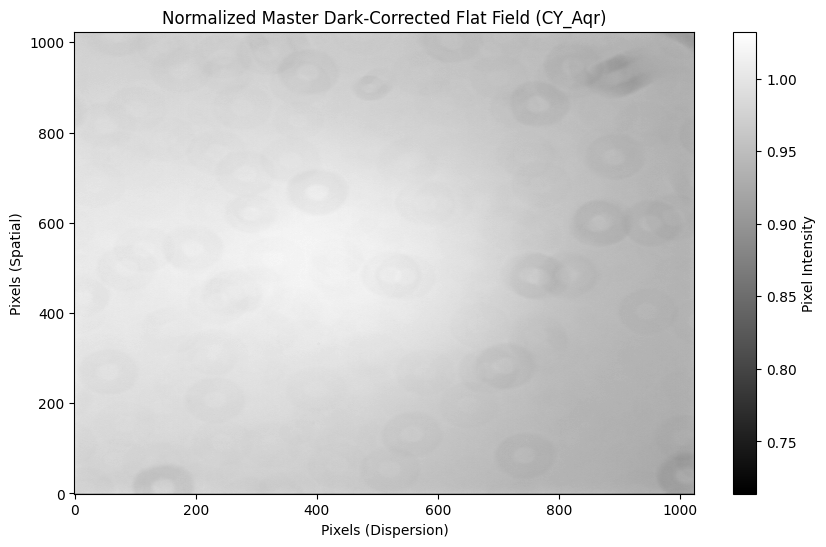

In [15]:
# Make the normalized master flat fields for CY_Aqr
normalized_master_flat_CY_Aqr = create_normalized_master_flat(flat_frames_dark_subtracted_cy_aqr, "CY_Aqr")

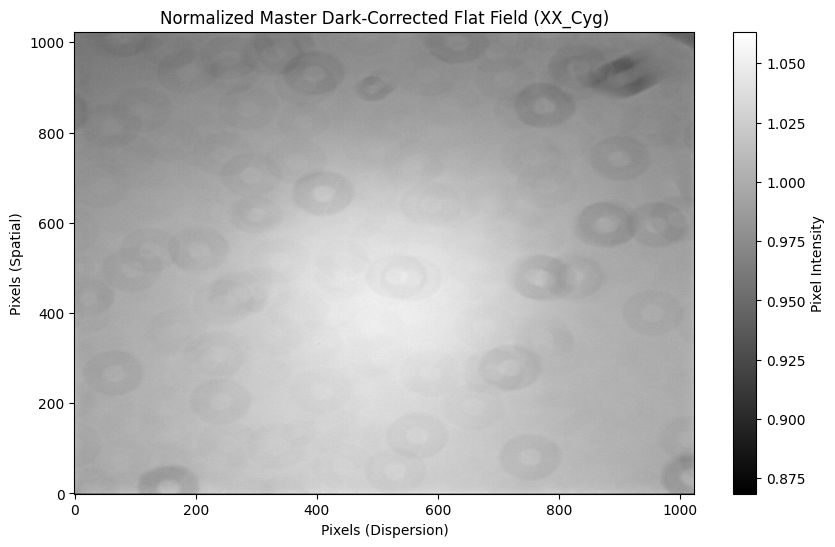

In [16]:
# Make the normalized master flat fields for XX_Cyg
normalized_master_flat_XX_Cyg = create_normalized_master_flat(flat_frames_dark_subtracted_xx_cyg, "XX_Cyg")

In [17]:
def apply_flat_correction(light_frames_dark_subtracted, normalized_master_flat, star_name):
    """
    Apply master flat field correction to dark-corrected light frames for a given star.
    The function also visualizes the corrected light frame for the first frame in the list.

    :param light_frames_dark_subtracted: List of tuples with headers and dark-corrected light frame data.
                                         Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type light_frames_dark_subtracted: list of tuples
    :param normalized_master_flat: Mode-normalized master flat field for flat field correction.
    :type normalized_master_flat: np.ndarray
    :param star_name: Name of the star for which flat correction is applied.
    :type star_name: str
    :return: List of tuples with headers and flat-corrected light frame data.
    :rtype: list of tuples
    """
    # Apply the master flat to each dark-corrected light frame
    flat_corrected_frames = [
        (header, data / normalized_master_flat) 
        for header, data in light_frames_dark_subtracted
    ]
    
    # Visualize the first flat-corrected light frame
    plt.figure(figsize=(10, 6))
    plt.imshow(flat_corrected_frames[0][1], cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title(f'Flat-Corrected Light Frame ({star_name})')
    plt.grid(False)
    plt.show()

    return flat_corrected_frames

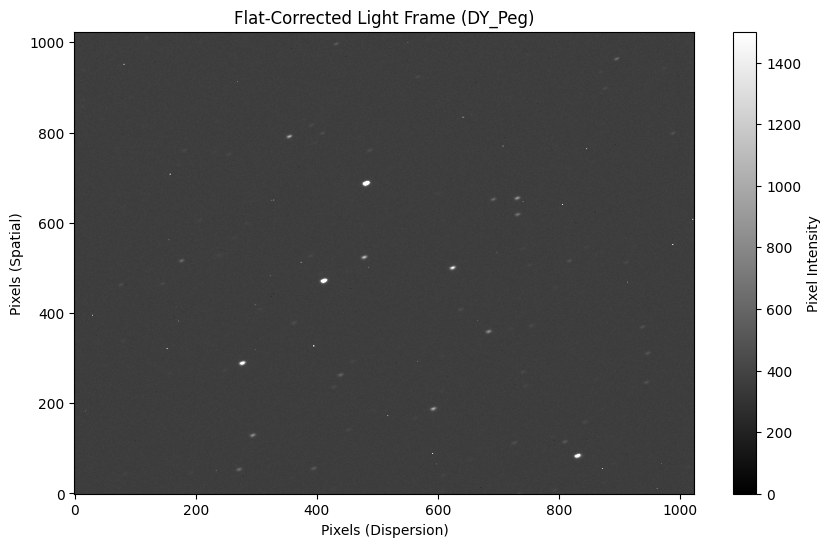

In [18]:
# Make the fully corrected light frames for DY_Peg
light_frames_flat_corrected_DY_Peg = apply_flat_correction(
    light_frames_dark_subtracted_dy_peg, normalized_master_flat_DY_Peg, "DY_Peg")

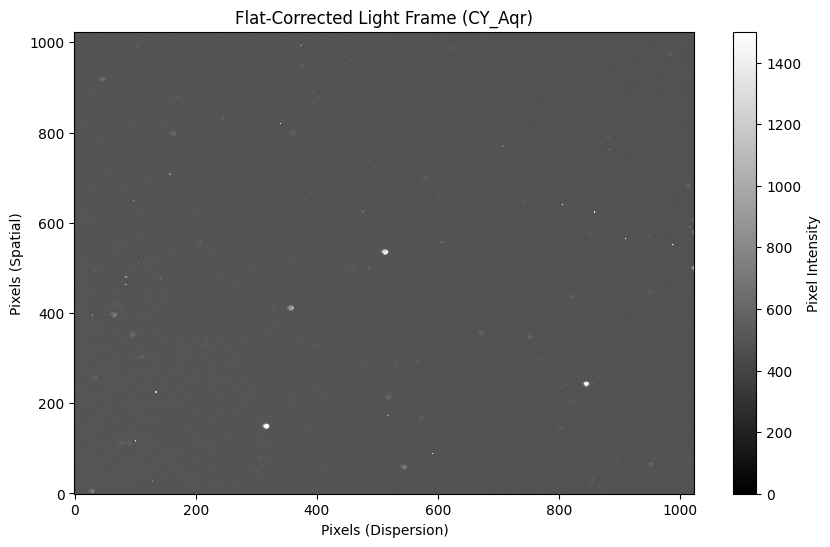

In [19]:
# Make the fully corrected light frames for CY_Aqr 
light_frames_flat_corrected_Cy_Aqr = apply_flat_correction(
    light_frames_dark_subtracted_cy_aqr, normalized_master_flat_CY_Aqr, "CY_Aqr")

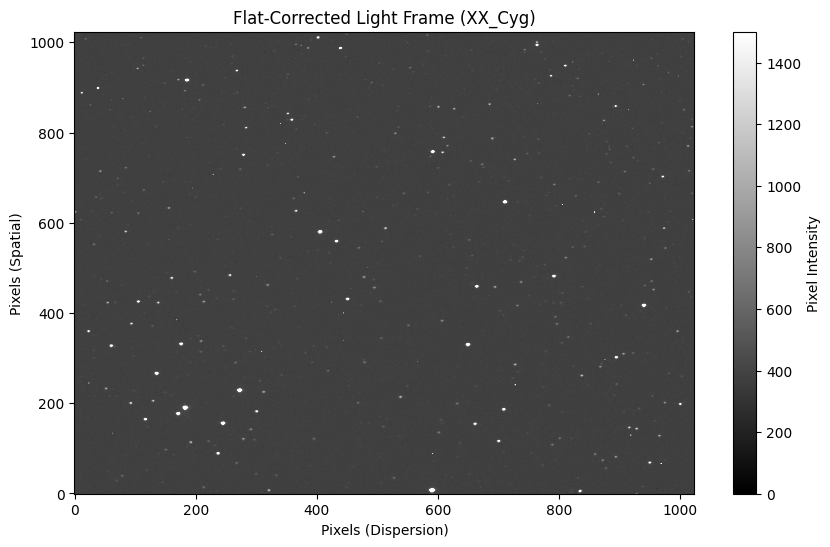

In [20]:
# Make the fully corrected light frames for XX_Cyg
light_frames_flat_corrected_XX_Cyg = apply_flat_correction(
    light_frames_dark_subtracted_xx_cyg, normalized_master_flat_XX_Cyg, "XX_Cyg")

In [21]:
def save_corrected_light_frames(corrected_light_frames, star_name, save_directory_base=r"..\FITS_Files_Corrected\Nov_5_DY_Peg"):
    """
    Save each flat-corrected light frame for a given star as an individual FITS file in the specified directory.

    :param corrected_light_frames: List of tuples with headers and flat-corrected light frame data.
                                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type corrected_light_frames: list of tuples
    :param star_name: Name of the star for which the corrected light frames are being saved.
    :type star_name: str
    :param save_directory_base: Base directory where the individual corrected light frames will be saved.
                                The corrected frames will be saved directly in this directory without any subfolders.
    :type save_directory_base: str
    :return: None
    :rtype: None
    """
    # Ensure the save directory exists
    os.makedirs(save_directory_base, exist_ok=True)

    for i, (header, data) in enumerate(corrected_light_frames):
        # Define the filename for each frame based on its series number
        filename = os.path.join(save_directory_base, f"{star_name}_corrected_frames_{i:04d}.fits")
        # Create a new FITS HDU with the corrected data and the original header
        hdu = fits.PrimaryHDU(data=data, header=header)
        # Write the FITS file to disk
        hdu.writeto(filename, overwrite=True)
        
        print(f"Saved {filename}")

In [22]:
# Saving the fully corrected light frames for DY_Peg
save_corrected_light_frames(
    light_frames_flat_corrected_DY_Peg, 
    "DY_Peg", save_directory_base=r"..\FITS_Files_Corrected\Nov_5_DY_Peg"
)

Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0000.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0001.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0002.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0003.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0004.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0005.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0006.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0007.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0008.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0009.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0010.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0011.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0012.fits

In [23]:
# Saving the fully corrected light frames for CY_Aqr
save_corrected_light_frames(
    light_frames_flat_corrected_Cy_Aqr, 
    "CY_Aqr", save_directory_base=r"..\FITS_Files_Corrected\Nov_7_CY_Aqr"
)

Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0000.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0001.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0002.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0003.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0004.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0005.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0006.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0007.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0008.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0009.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0010.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0011.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_0012.fits

In [24]:
# Saving the fully corrected light frames for XX_Cyg
save_corrected_light_frames(
    light_frames_flat_corrected_XX_Cyg, 
    "XX_Cyg", save_directory_base=r"..\FITS_Files_Corrected\Nov_9_XX_Cyg"
)

Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0000.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0001.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0002.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0003.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0004.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0005.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0006.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0007.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0008.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0009.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0010.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0011.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0012.fits

##### Section 4.2: Running frames through Astronomy.net 

In [25]:
def process_star_data(file_template, num_files, exclude_frames, results_directory, header_directory):
    """
    Process star data, detect sources, save results, and store WCS headers.

    :param file_template: Template for the FITS file paths with placeholders for file indices.
    :type file_template: str
    :param num_files: Total number of files to process.
    :type num_files: int
    :param exclude_frames: List of frame indices to exclude from processing.
    :type exclude_frames: list
    :param results_directory: Directory to save the source catalog results.
    :type results_directory: str
    :param header_directory: Directory to save the WCS headers.
    :type header_directory: str
    :return: None. The function saves the results to the specified directories.
    :rtype: None
    """
    # Create a Gaussian kernel for convolution
    gaussian_stddev = 2  # Standard deviation for Gaussian kernel
    gaussian_kernel = Gaussian2DKernel(gaussian_stddev)

    # Make sure directories exist
    os.makedirs(results_directory, exist_ok=True)
    os.makedirs(header_directory, exist_ok=True)

    # Parameters for source detection
    threshold_sigma = 2.0  # Detection threshold in sigma
    npixels = 5  # Minimum number of connected pixels above the threshold

    # Loop through all files
    for i in range(num_files):
        if i in exclude_frames:
            print(f"Skipping frame {i:04d}")
            continue  # Skip the excluded frames
        
        file_path = file_template.format(i=i)
        try:
            print(f"Processing file: {file_path}")
            
            # Solve for WCS using Astrometry.net
            wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
            # Save the WCS header to a file
            header_file_path = os.path.join(header_directory, f"wcs_header_frame_{i:04d}.txt")
            with open(header_file_path, "w") as header_file:
                for key, value in wcs_header.items():
                    header_file.write(f"{key}: {value}\n")
            print(f"Saved WCS header to {header_file_path}")
            # Read the original FITS file to get the data
            with fits.open(file_path) as hdul:
                original_data = hdul[0].data  # Get the image data
                header = hdul[0].header
            # Combine the WCS header with the existing header
            for key, value in wcs_header.items():
                header[key] = value
            # Create WCS object
            wcs = WCS(header)
            # Apply Gaussian smoothing
            smoothed_data = convolve(original_data, gaussian_kernel, normalize_kernel=True)
            # Calculate the detection threshold
            mean, median, std = sigma_clipped_stats(smoothed_data, sigma=3.0)
            threshold = median + (threshold_sigma * std)
            # Detect sources in the image
            segmentation_map = detect_sources(smoothed_data, threshold, npixels=npixels)
            # Create the source catalog
            catalog = SourceCatalog(original_data, segmentation_map, wcs=wcs)
            # Extract source properties
            source_fluxes = catalog.segment_flux  # Correct attribute for source flux
            source_coordinates = catalog.sky_centroid  # RA and Dec for each source

            # Save results to a file
            results_path = os.path.join(results_directory, f"source_catalog_frame_{i:04d}.txt")
            with open(results_path, "w") as f:
                f.write("# Source Fluxes and Coordinates\n")
                f.write("# Flux (e-/s), RA (deg), Dec (deg)\n")
                for flux, coord in zip(source_fluxes, source_coordinates):
                    ra, dec = coord.ra.deg, coord.dec.deg
                    f.write(f"{flux:.3f}, {ra:.6f}, {dec:.6f}\n")
            
            print(f"Saved source catalog to {results_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

In [ ]:
# Define parameters for CY Aqr
file_template = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr\CY_Aqr_corrected_frames_{i:04d}.fits"
num_files = 200  # Total number of files

# Include only the specified frames and exclude the rest
include_frames = [
    55, 57, 59, 60, 61, 62, 63, 65, 69, 70, 71, 72, 77, 80, 81, 88, 89, 90, 91, 92,
    95, 96, 101, 102, 106, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122,
    125, 126, 127, 128, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
    145, 146, 147, 148, 149, 150, 151, 152, 153, *range(154, 200)
]
exclude_frames = [i for i in range(num_files) if i not in include_frames]

# Set directories for results and WCS headers
results_directory = r"..\FITS_Files_WCS_Headers\Nov_7_CY_Aqr\source_catalog"
header_directory = r"..\FITS_Files_WCS_Headers\Nov_7_CY_Aqr\wcs_header_frame"

# Call the process_star_data function for CY Aqr
process_star_data(file_template, num_files, exclude_frames, results_directory, header_directory)

In [ ]:
# Define parameters for XX_Cyg
file_template = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_{i:04d}.fits"
num_files = 350  # Total number of files 

# Exclude frames 35 and 250
exclude_frames = [i for i in range(num_files) if i == 35 or i == 250]

# Directories for saving the results and WCS headers
results_directory = r"..\FITS_Files_WCS_Headers\Nov_9_XX_Cyg\source_catalog"
header_directory = r"..\FITS_Files_WCS_Headers\Nov_9_XX_Cyg\wcs_header_frame"

# Call the process_star_data function for XX_Cyg
process_star_data(file_template, num_files, exclude_frames, results_directory, header_directory)

In [ ]:
# Define parameters for DY_Peg
file_template = r"..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_{i:04d}.fits"
num_files = 241 # Total number of files 
# Exclude frames 67-71, 122, and 210
exclude_frames = exclude_frames = [i for i in range(num_files) if i in range(67, 72) or i == 122 or i == 210] 
results_directory = r"..\FITS_Files_WCS_Headers\Nov_5_DY_Peg\source_catalog"
header_directory = r"..\FITS_Files_WCS_Headers\Nov_5_DY_Peg\wcs_header_frame"

# Call the process_star_data function for DY_Peg
process_star_data(file_template, num_files, exclude_frames, results_directory, header_directory)

In [26]:
def read_wcs_headers(header_directory):
    """
    Reads all WCS header files from the specified directory.

    :param header_directory: Directory containing WCS header files.
    :type header_directory: str
    :return: Dictionary with frame indices as keys and WCS parameters as values.
    :rtype: dict
    """
    wcs_data = {}
    # List all WCS header files
    header_files = sorted([f for f in os.listdir(header_directory) if f.endswith(".txt")])
    for header_file in header_files:
        frame_index = int(header_file.split("_")[-1].split(".")[0])  # Extract frame index
        header_path = os.path.join(header_directory, header_file)
        wcs_params = {}
        with open(header_path, 'r') as f:
            for line in f:
                line = line.strip()
                if ':' not in line or not line:
                    continue
                key, value = line.split(':', 1)
                key = key.strip()
                value = value.strip()
                # Convert value to appropriate type
                if value.replace('.', '', 1).isdigit():  # Check if it's a number
                    value = float(value) if '.' in value else int(value)
                wcs_params[key] = value
        # Store WCS parameters for the current frame
        wcs_data[frame_index] = wcs_params

    return wcs_data

In [27]:
def apply_icrs_wcs_to_light_frames(wcs_data, file_template):
    """
    Applies WCS information (in ICRS format) to light frames' FITS files using the provided WCS data.

    :param wcs_data: Dictionary with frame indices as keys and WCS parameters as values.
    :type wcs_data: dict
    :param file_template: Template for the FITS file paths with placeholders for file indices.
    :type file_template: str
    :return: None. The function modifies FITS files in-place by adding WCS information.
    :rtype: None
    """
    for frame_index, wcs_params in wcs_data.items():
        fits_file = file_template.format(i=frame_index)

        try:
            # Retrieve WCS-related parameters
            crval1 = float(wcs_params.get("CRVAL1", 0.0))  # RA in degrees
            crval2 = float(wcs_params.get("CRVAL2", 0.0))  # Dec in degrees
            crpix1 = float(wcs_params.get("CRPIX1", 0.0))  # Reference pixel x
            crpix2 = float(wcs_params.get("CRPIX2", 0.0))  # Reference pixel y
            cd11 = float(wcs_params.get("CD1_1", 0.0))  # CD matrix element
            cd12 = float(wcs_params.get("CD1_2", 0.0))
            cd21 = float(wcs_params.get("CD2_1", 0.0))
            cd22 = float(wcs_params.get("CD2_2", 0.0))

            # Create a WCS object from the parameters
            wcs = WCS(naxis=2)
            wcs.wcs.crval = [crval1, crval2]  # Reference RA/Dec
            wcs.wcs.crpix = [crpix1, crpix2]  # Reference pixel
            wcs.wcs.cd = [[cd11, cd12], [cd21, cd22]]  # Transformation matrix
            wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]  # Tangential projection

            # Open the FITS file and apply WCS information
            with fits.open(fits_file, mode="update") as hdul:
                header = hdul[0].header

                # Add WCS to the header
                wcs_header = wcs.to_header()
                header.update(wcs_header)

                # Ensure coordinates are in ICRS format
                skycoord = SkyCoord(crval1, crval2, unit="deg", frame="icrs")
                header["OBJCTRA"] = skycoord.ra.to_string(unit="hourangle", sep=":", precision=3)
                header["OBJCTDEC"] = skycoord.dec.to_string(unit="deg", sep=":", precision=3)

                # Save changes to the file
                hdul.flush()
                print(f"WCS applied to frame {frame_index} and saved to {fits_file}")

        except Exception as e:
            print(f"Error processing frame {frame_index}: {e}")

In [28]:
# Define parameters for DY_Peg
header_directory = r"..\FITS_Files_WCS_Headers\Nov_5_DY_Peg\wcs_header_frame"
file_template = r"..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_{i:04d}.fits"

# Frames to exclude
exclude_frames = {67, 68, 69, 70, 71, 122, 210}  # Explicitly ignore these frames

# Step 1: Read WCS headers
wcs_data = read_wcs_headers(header_directory)

# Filter WCS data to exclude the specified frames
filtered_wcs_data = {key: value for key, value in wcs_data.items() if key not in exclude_frames}

# Step 2: Apply RA/Dec to light frames
apply_icrs_wcs_to_light_frames(filtered_wcs_data, file_template)

WCS applied to frame 0 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0000.fits
WCS applied to frame 1 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0001.fits
WCS applied to frame 2 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0002.fits
WCS applied to frame 3 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0003.fits
WCS applied to frame 4 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0004.fits
WCS applied to frame 5 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0005.fits
WCS applied to frame 6 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0006.fits
WCS applied to frame 7 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0007.fits
WCS applied to frame 8 and saved to ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0008.fits
WCS applied to frame 9 and saved to .

In [29]:
# Define parameters for XX Cyg
header_directory = r"..\FITS_Files_WCS_Headers\Nov_9_XX_Cyg\wcs_header_frame"
file_template = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_{i:04d}.fits"

# Frames to exclude
exclude_frames = {35, 250}  # Explicitly ignore these frames

# Step 1: Read WCS headers
wcs_data = read_wcs_headers(header_directory)

# Filter WCS data to exclude the specified frames
filtered_wcs_data = {key: value for key, value in wcs_data.items() if key not in exclude_frames}

# Step 2: Apply RA/Dec to light frames
apply_icrs_wcs_to_light_frames(filtered_wcs_data, file_template)

WCS applied to frame 0 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0000.fits
WCS applied to frame 1 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0001.fits
WCS applied to frame 2 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0002.fits
WCS applied to frame 3 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0003.fits
WCS applied to frame 4 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0004.fits
WCS applied to frame 5 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0005.fits
WCS applied to frame 6 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0006.fits
WCS applied to frame 7 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0007.fits
WCS applied to frame 8 and saved to ..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_0008.fits
WCS applied to frame 9 and saved to .

##### Section 4.3: Ruuning through Source Extractor and generating light curves

In [30]:
def read_time_obs_as_jd(fits_path):
    """
    Reads the DATE-OBS value from the FITS file header and converts it into Julian Date (JD).
    
    :param fits_path: Path to the FITS file.
    :type fits_path: str
    :return: Observation time in Julian Date (JD).
    :rtype: float
    """
    with fits.open(fits_path) as hdul:
        # Get the DATE-OBS value from the header
        date_obs = hdul[0].header.get("DATE-OBS", None)
        if date_obs is None:
            raise ValueError("DATE-OBS keyword not found in FITS header.")
    
    # Convert the DATE-OBS string to Julian Date using astropy
    observation_time = Time(date_obs, format="isot", scale="utc")
    return observation_time.jd

def parse_coordinates(ra, dec):
    """
    Converts RA/Dec from degrees to hours:minutes:seconds and degrees:minutes:seconds.
    
    :param ra: Right Ascension in degrees.
    :type ra: float
    :param dec: Declination in degrees.
    :type dec: float
    :return: RA and Dec in hours:minutes:seconds and degrees:minutes:seconds format.
    :rtype: tuple
    """
    coord = SkyCoord(ra=ra, dec=dec, unit=("deg", "deg"))
    return coord.to_string("hmsdms", sep=":").split()

In [31]:
def match_target(cat_data, target_ra, target_dec, match_tolerance=0.01):
    """
    Matches a target RA/Dec to the closest entry in catalog data.
    
    :param cat_data: Catalog data with RA/Dec in degrees.
    :type cat_data: numpy.ndarray
    :param target_ra: Target Right Ascension in hours:minutes:seconds.
    :type target_ra: str
    :param target_dec: Target Declination in degrees:minutes:seconds.
    :type target_dec: str
    :param match_tolerance: Maximum allowed distance for a match in degrees.
    :type match_tolerance: float
    :return: Matched flux and flux error, or None if no match is found.
    :rtype: tuple or None
    """
    # Convert target RA/Dec to degrees
    target_coord = SkyCoord(target_ra, target_dec, unit=("hourangle", "deg"))
    target_ra_deg = target_coord.ra.deg
    target_dec_deg = target_coord.dec.deg

    # Compute distances
    distances = np.sqrt(
        (cat_data["ALPHA_J2000"] - target_ra_deg) ** 2 +
        (cat_data["DELTA_J2000"] - target_dec_deg) ** 2
    )
    match_idx = np.argmin(distances)
    if distances[match_idx] <= match_tolerance:
        return cat_data["FLUX_APER"][match_idx], cat_data["FLUXERR_APER"][match_idx]
    return None, None

In [32]:
def process_frames(fits_template, cat_template, targets, excluded_frames, total_frames):
    """
    Processes all frames to create light curves for targets and generates a single plot.

    :param fits_template: Template for FITS file paths.
    :type fits_template: str
    :param cat_template: Template for .cat file paths.
    :type cat_template: str
    :param targets: List of target dictionaries with name, RA, and Dec.
    :type targets: list
    :param excluded_frames: Set of frame indices to exclude.
    :type excluded_frames: set
    :param total_frames: Total number of frames to process (excluding excluded frames).
    :type total_frames: int
    :return light_curves: A dictionary containing the light curves for all targets.
             Each target has keys "time", "flux", and "fluxerr".
    :rtype light_curves: dict
    """
    light_curves = {target["name"]: {"time": [], "flux": [], "fluxerr": []} for target in targets}
    processed_frames = 0  # Counter for processed frames

    for i in range(0, total_frames + 1):
        if i in excluded_frames:
            continue
        # Read time from FITS file
        fits_path = fits_template.format(i=i)
        if not os.path.exists(fits_path):
            print(f"Warning: FITS file {fits_path} not found. Skipping.")
            continue
        time_obs = read_time_obs_as_jd(fits_path) 
        
        # Read catalog file
        cat_path = cat_template.format(i=i)
        if not os.path.exists(cat_path):
            print(f"Warning: Catalog file {cat_path} not found. Skipping.")
            continue

        # Load catalog data (columns 1, 2, 7, 8: flux, flux error, RA, Dec)
        try:
            cat_data = np.loadtxt(
                cat_path,
                comments="#",  # Skip comment lines
                usecols=(1, 2, 7, 8),  # FLUX_APER, FLUXERR_APER, ALPHA_J2000, DELTA_J2000
                dtype={
                    "names": ("FLUX_APER", "FLUXERR_APER", "ALPHA_J2000", "DELTA_J2000"),
                    "formats": ("f8", "f8", "f8", "f8"),
                },
            )
        except Exception as e:
            print(f"Error loading {cat_path}: {e}")
            continue

        # Match targets and collect data
        for target in targets:
            target_name = target["name"]
            flux, fluxerr = match_target(cat_data, target["ra"], target["dec"])
            if flux is not None:
                light_curves[target_name]["time"].append(time_obs)
                light_curves[target_name]["flux"].append(flux)
                light_curves[target_name]["fluxerr"].append(fluxerr)
        processed_frames += 1
    if processed_frames == 0:
        print("No frames processed. Check your input data.")
        return

    # Extract the name of the first target for the title
    main_target_name = targets[0]["name"]
    # Define a fixed set of distinct colors (expandable if necessary)
    fixed_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#393b79"
    ]
    # Plot light curves for target and reference stars
    plt.figure(figsize=(12, 8))
    for idx, target in enumerate(targets):  # Use enumerate to track index
        target_name = target["name"]
        data = light_curves[target_name]
        # Parse times with explicit format
        times = np.array(data["time"])
        flux = np.array(data["flux"])
        fluxerr = np.array(data["fluxerr"])
        # Assign colors explicitly from the fixed_colors list
        color = fixed_colors[idx % len(fixed_colors)] 
        plt.errorbar(
            times,
            flux,
            yerr=fluxerr,
            label=f"{target_name}",
            fmt="o",
            markersize = 1,
            capsize=3,
            color=color  
        )
    # Create a dynamic title using the first target
    plt.title(f"Light Curves for Target and Reference Objects: {main_target_name}")
    plt.xlabel("Time (JD)")
    plt.ylabel("Flux (Counts)")
    plt.legend(loc="best", fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()

    return light_curves

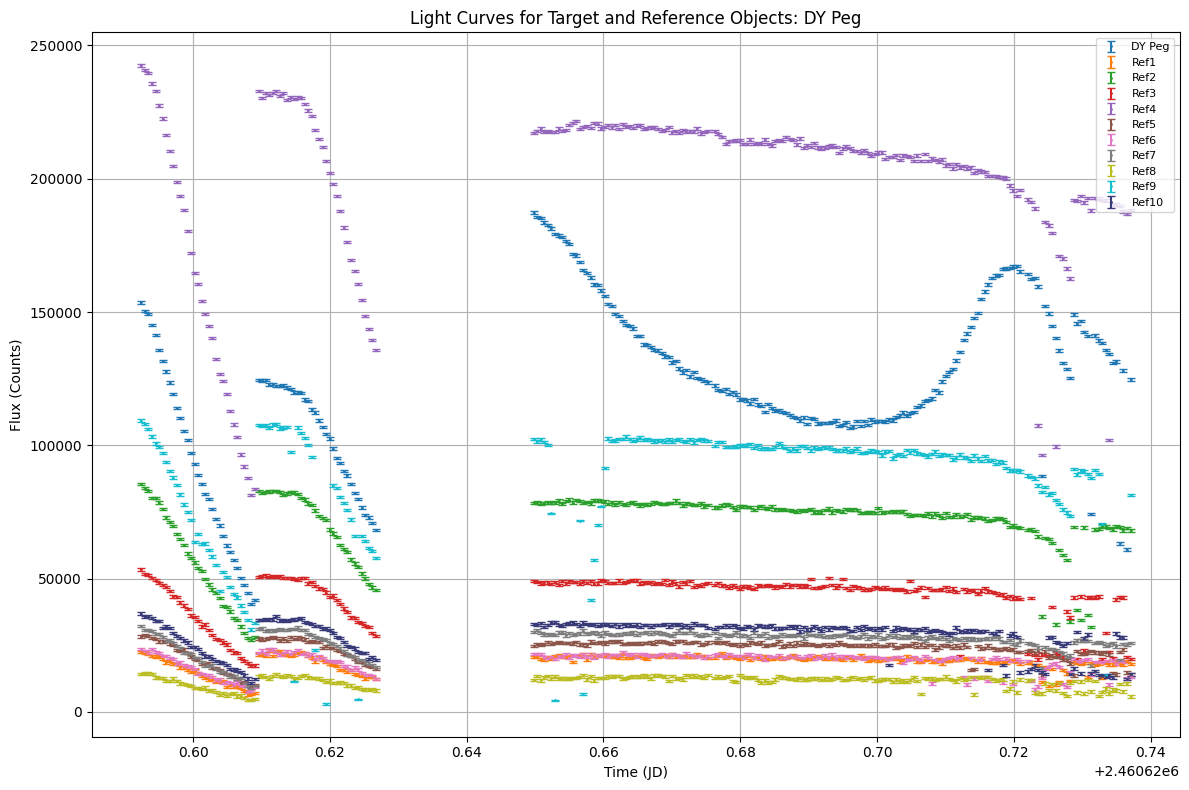

In [33]:
# Generating light curvers for DY Peg and reference objects
light_curves_DY_Peg = process_frames(
    fits_template=r"..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_{i:04d}.fits",
    cat_template=r"..\sextractor\Nov_5_DY_Peg\DY_Peg_corrected_frames_{i:04d}_output.cat",
    targets=[
        {"name": "DY Peg", "ra": "23:08:51.1858", "dec": "+17:12:55.9975"},
        {"name": "Ref1", "ra": "23:08:29.8110", "dec": "+17:20:20.577"},
        {"name": "Ref2", "ra": "23:08:44.0318", "dec": "+17:18:20.131"},
        {"name": "Ref3", "ra": "23:08:40.4670", "dec": "+17:08:13.035"},
        {"name": "Ref4", "ra": "23:09:05.0202", "dec": "+17:08:20.791"},
        {"name": "Ref5", "ra": "23:09:21.5329", "dec": "+17:09:21.035"},
        {"name": "Ref6", "ra": "23:08:46.8947", "dec": "+17:03:49.763"},
        {"name": "Ref7", "ra": "23:08:16.3173", "dec": "+17:13:27.829"},
        {"name": "Ref8", "ra": "23:08:43.7504", "dec": "+17:04:20.939"},
        {"name": "Ref9", "ra": "23:07:52.7561", "dec": "+17:10:14.025"},
        {"name": "Ref10", "ra": "23:08:51.2921", "dec": "+17:10:50.856"},
    ],
    excluded_frames={67, 68, 69, 70, 71, 122, 210},
    total_frames=240
)

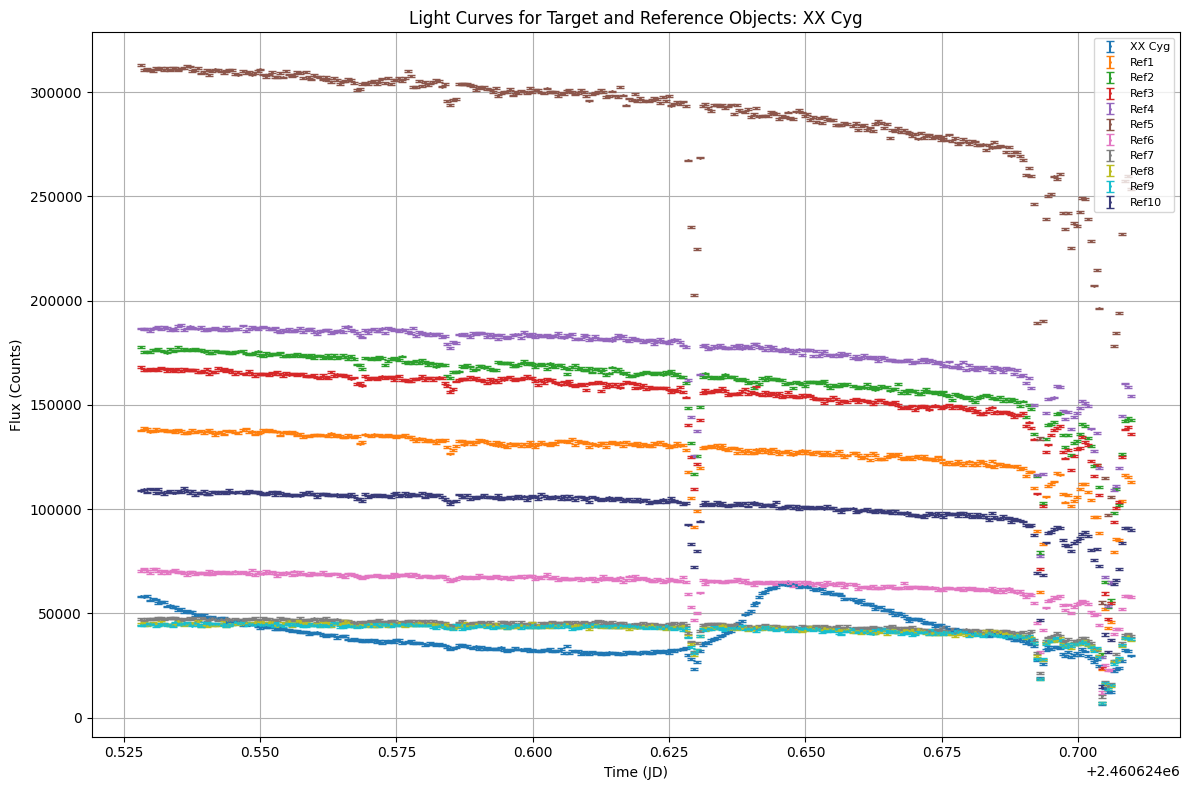

In [34]:
# Generating light curvers for XX Cyg and reference objects
light_curves_XX_Cyg = process_frames(
    fits_template=r"..\FITS_Files_Corrected\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_{i:04d}.fits",
    cat_template=r"..\sextractor\Nov_9_XX_Cyg\XX_Cyg_corrected_frames_{i:04d}_output.cat",
    targets=[
        {"name": "XX Cyg", "ra": "20:03:15.6420", "dec": "+58:57:16.525"},
        {"name": "Ref1", "ra": "20:03:35.8800", "dec": "+58:55:21.437"},
        {"name": "Ref2", "ra": "20:03:49.2751", "dec": "+59:02:42.045"},
        {"name": "Ref3", "ra": "20:02:48.8195", "dec": "+59:00:35.145"},
        {"name": "Ref4", "ra": "20:02:30.6018", "dec": "+58:53:08.784"},
        {"name": "Ref5", "ra": "20:03:16.6345", "dec": "+58:45:57.253"},
        {"name": "Ref6", "ra": "20:03:24.1649", "dec": "+59:00:18.727"},
        {"name": "Ref7", "ra": "20:04:05.6954", "dec": "+58:54:50.403"},
        {"name": "Ref8", "ra": "20:02:59.8530", "dec": "+58:52:19.079"},
        {"name": "Ref9", "ra": "20:02:36.8885", "dec": "+58:53:31.080"},
        {"name": "Ref10", "ra": "20:02:18.6222", "dec": "+58:59:23.204"},
    ],
    excluded_frames={35, 250},
    total_frames=349
)

##### Section 4.4: Rescaling light curves of reference stars

In [35]:
def clean_light_curves(light_curves, placeholder=0.001):
    """
    Removes data points with a flux value equal to the placeholder from 
    the light curves.

    :param light_curves: Dictionary containing light curves for all targets.
                         Each target has keys "time", "flux", and "fluxerr".
    :type light_curves: dict
    :param placeholder: Placeholder value for flux indicating missing or invalid data.
                        Default is 0.001.
    :type placeholder: float
    :return: Tuple containing updated light_curves with placeholder values removed.
    :rtype: (dict, dict)
    """
    # Make a deep copy of the original light curves for uncleaned data
    uncleaned_light_curves = {key: value.copy() for key, value in light_curves.items()}
    # Initialize the cleaned_light_curves dictionary
    cleaned_light_curves = {}
    for target_name, data in light_curves.items():
        # Convert lists to NumPy arrays
        time = np.array(data["time"])
        flux = np.array(data["flux"])
        fluxerr = np.array(data["fluxerr"])
        # Create a mask to filter out placeholder or invalid flux values
        valid_mask = flux != placeholder
        # Apply the mask to remove invalid data points
        cleaned_light_curves[target_name] = {
            "time": time[valid_mask].tolist(),
            "flux": flux[valid_mask].tolist(),
            "fluxerr": fluxerr[valid_mask].tolist(),
        }

    return uncleaned_light_curves, cleaned_light_curves

In [36]:
def rescale_flux(light_curves, cleaned_data=None):
    """
    Calculates the mean flux for each star over the total observation period and rescales
    the flux and flux error by dividing by the respective average flux. This is done separately
    for both the uncleaned and cleaned data.

    :param light_curves: Dictionary containing the original light curves for all targets
    :type light_curves: dict
    :param cleaned_data: Dictionary containing the cleaned light curves for all targets
    or None if cleaning was not performed.    
    :type cleaned_data: dict or None
    :return: Two dictionaries containing rescaled flux and flux error: `rescaled_uncleaned`
    and `rescaled_cleaned`
    :rtype: (dict, dict)
    """
    rescaled_uncleaned = {}
    rescaled_cleaned = {} if cleaned_data else None
    # Helper function to calculate rescaled data
    def rescale_data(data):
        rescaled = {}
        for target_name, target_data in data.items():
            # Calculate average flux for the target
            ave_flux = np.mean(target_data["flux"])
            
            # Rescale flux and flux error
            rescaled[target_name] = {
                "time": target_data["time"],
                "flux": np.array(target_data["flux"]) / ave_flux,
                "fluxerr": np.array(target_data["fluxerr"]) / ave_flux,
            }
        return rescaled

    rescaled_uncleaned = rescale_data(light_curves)
    rescaled_cleaned = rescale_data(cleaned_data) if cleaned_data else None

    return rescaled_uncleaned, rescaled_cleaned

In [37]:
def plot_light_curves_comparison(light_curves, cleaned_light_curves, targets):
    """
    Plots the uncleaned and cleaned light curves in separate plots for comparison.

    :param light_curves: Dictionary containing uncleaned light curves for all targets.
    :type light_curves: dict
    :param cleaned_light_curves: Dictionary containing cleaned light curves for all targets.
    :type cleaned_light_curves: dict
    :param targets: List of target dictionaries with name, RA, and Dec.
    :type targets: list
    """
    # Extract the name of the first target for the title
    main_target_name = targets[0]["name"]
    
    # Define a fixed set of distinct colors (expandable if necessary)
    fixed_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#393b79"
    ]
    # Plot uncleaned light curves
    plt.figure(figsize=(12, 8))
    for idx, (target_name, data) in enumerate(light_curves.items()):
        # Ensure time is treated as Julian Date
        time_jd = np.array(data["time"])
        flux = np.array(data["flux"])
        fluxerr = np.array(data["fluxerr"])
        color = fixed_colors[idx % len(fixed_colors)]
        plt.errorbar(
            time_jd, flux, label=f"{target_name}", fmt="o", markersize = 2, capsize=3, alpha=0.6,
            color=color
        )
    plt.title(f"Uncleaned Light Curves for Target and Reference Objects: {main_target_name}")
    plt.xlabel("Time")
    plt.ylabel("Flux (Counts)")
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot cleaned light curves
    plt.figure(figsize=(12, 8))
    for idx, (target_name, data) in enumerate(cleaned_light_curves.items()):
        # Ensure time is treated as Julian Date
        time_jd = np.array(data["time"])
        flux = np.array(data["flux"])
        fluxerr = np.array(data["fluxerr"])
        color = fixed_colors[idx % len(fixed_colors)]
        plt.errorbar(
            time_jd, flux, label=f"{target_name}", fmt="o", markersize = 2, capsize=3, alpha=0.8,
            color=color
        )
    plt.title(f"Cleaned Light Curves for Target and Reference Objects: {main_target_name}")
    plt.xlabel("Time")
    plt.ylabel("Flux (Counts)")
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

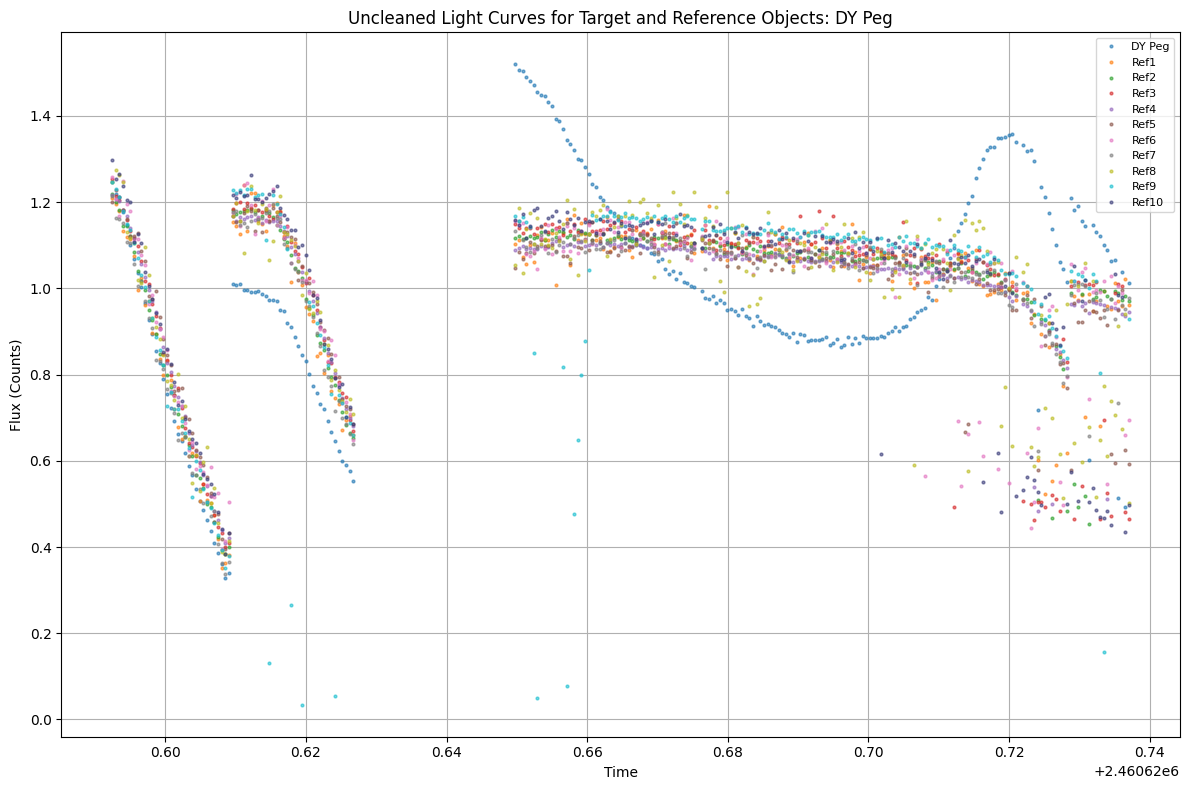

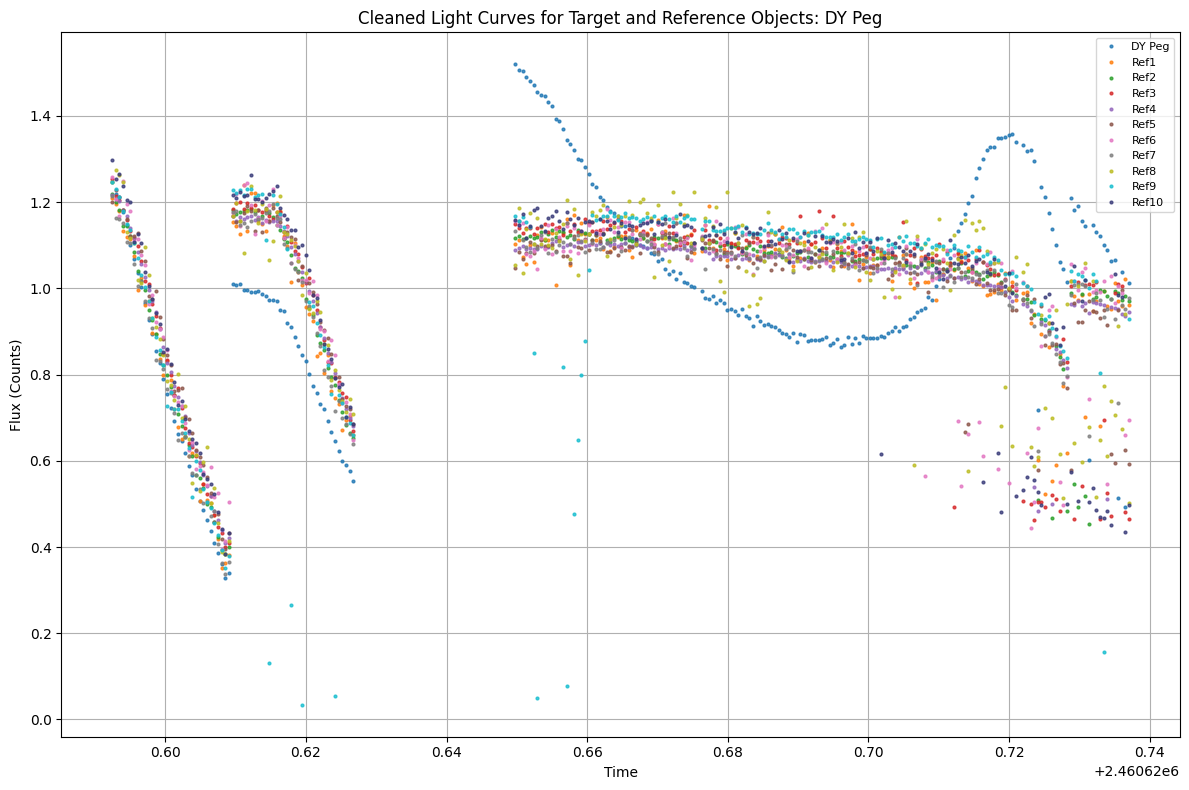

In [38]:
# Running through all functions for DY Peg and target list 
uncleaned_light_curves_DY_Peg, cleaned_light_curves_DY_Peg = clean_light_curves(light_curves_DY_Peg)
rescaled_uncleaned_DY_Peg, rescaled_cleaned_DY_Peg = rescale_flux(uncleaned_light_curves_DY_Peg, cleaned_light_curves_DY_Peg)
plot_light_curves_comparison(rescaled_uncleaned_DY_Peg, rescaled_cleaned_DY_Peg, targets=[
        {"name": "DY Peg", "ra": "23:08:51.1858", "dec": "+17:12:55.9975"},
        {"name": "Ref1", "ra": "23:08:29.8110", "dec": "+17:20:20.577"},
        {"name": "Ref2", "ra": "23:08:44.0318", "dec": "+17:18:20.131"},
        {"name": "Ref3", "ra": "23:08:40.4670", "dec": "+17:08:13.035"},
        {"name": "Ref4", "ra": "23:09:05.0202", "dec": "+17:08:20.791"},
        {"name": "Ref5", "ra": "23:09:21.5329", "dec": "+17:09:21.035"},
        {"name": "Ref6", "ra": "23:08:46.8947", "dec": "+17:03:49.763"},
        {"name": "Ref7", "ra": "23:08:16.3173", "dec": "+17:13:27.829"},
        {"name": "Ref8", "ra": "23:08:43.7504", "dec": "+17:04:20.939"},
        {"name": "Ref9", "ra": "23:08:16.3756", "dec": "+17:13:28.127"},
        {"name": "Ref10", "ra": "23:08:43.9870", "dec": "+17:04:22.202"},
    ])

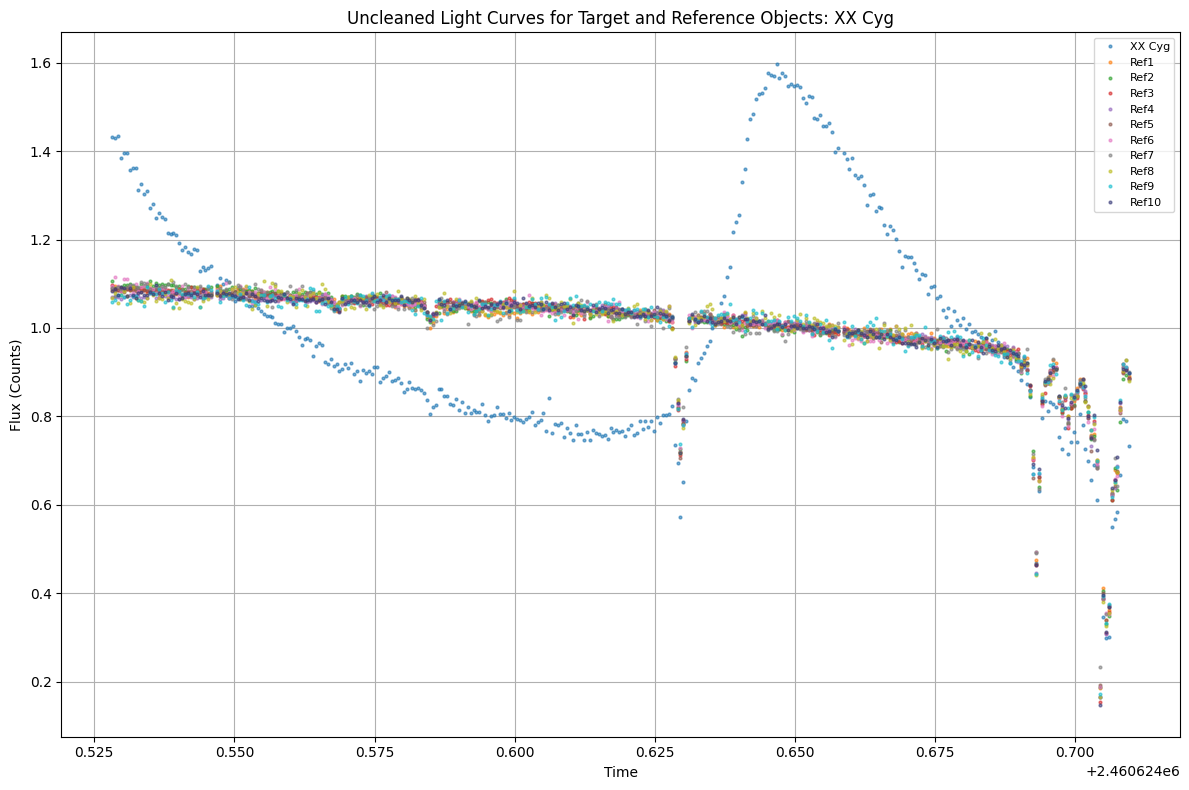

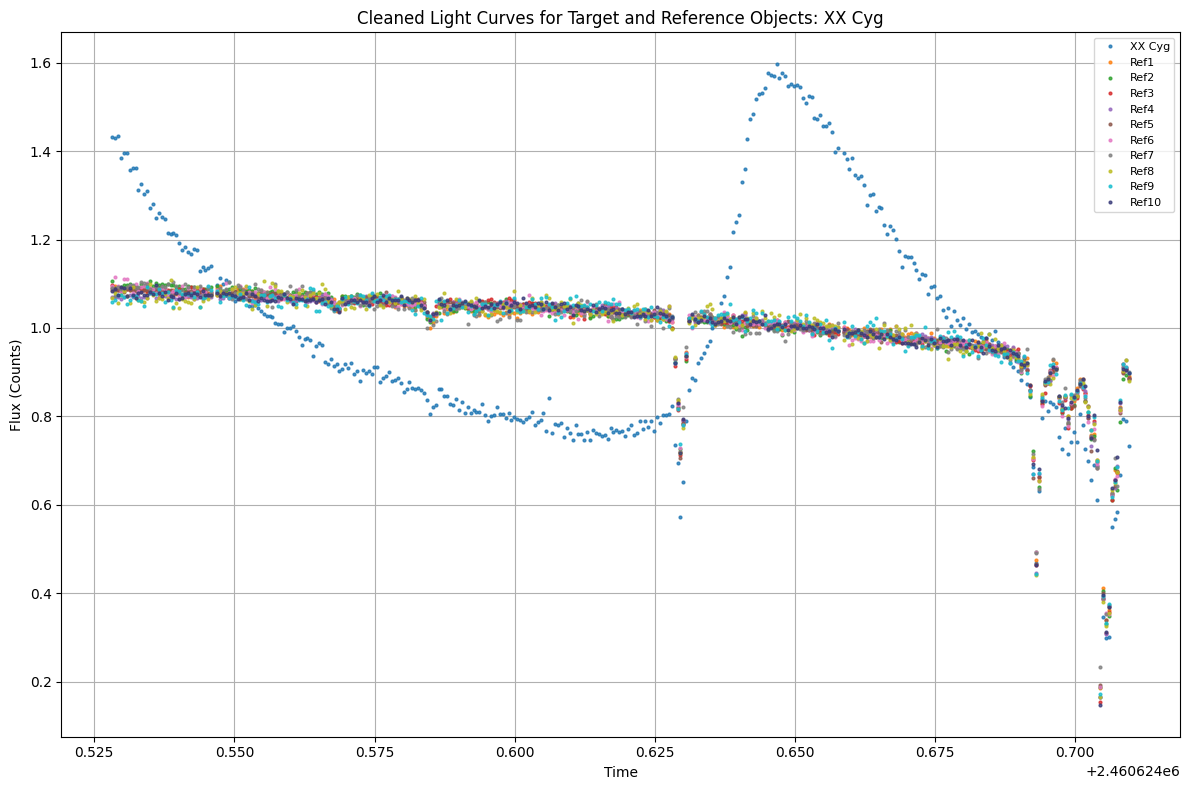

In [39]:
# Running through all functions for XX Cyg and target list 
uncleaned_light_curves_XX_Cyg, cleaned_light_curves_XX_Cyg = clean_light_curves(light_curves_XX_Cyg)
rescaled_uncleaned_XX_Cyg, rescaled_cleaned_XX_Cyg = rescale_flux(uncleaned_light_curves_XX_Cyg, cleaned_light_curves_XX_Cyg)
plot_light_curves_comparison(rescaled_uncleaned_XX_Cyg, rescaled_cleaned_XX_Cyg, targets=[
        {"name": "XX Cyg", "ra": "20:03:15.6420", "dec": "+58:57:16.525"},
        {"name": "Ref1", "ra": "20:03:35.8800", "dec": "+58:55:21.437"},
        {"name": "Ref2", "ra": "20:03:49.2751", "dec": "+59:02:42.045"},
        {"name": "Ref3", "ra": "20:02:48.8195", "dec": "+59:00:35.145"},
        {"name": "Ref4", "ra": "20:02:30.6018", "dec": "+58:53:08.784"},
        {"name": "Ref5", "ra": "20:03:16.6345", "dec": "+58:45:57.253"},
        {"name": "Ref6", "ra": "20:03:24.1649", "dec": "+59:00:18.727"},
        {"name": "Ref7", "ra": "20:04:05.6954", "dec": "+58:54:50.403"},
        {"name": "Ref8", "ra": "20:02:59.8530", "dec": "+58:52:19.079"},
        {"name": "Ref9", "ra": "20:02:36.8885", "dec": "+58:53:31.080"},
        {"name": "Ref10", "ra": "20:02:18.6222", "dec": "+58:59:23.204"},
    ])

##### Section 4.5: Calibration of the Science Target Photometry

In [40]:
def calculate_weighted_mean_and_error(reference_fluxes, reference_flux_errors, cleaned_data=None):
    """
    Calculates the weighted mean flux and its associated error for a set of targets (including reference stars and the target object).

    :param reference_fluxes: A list of 1D numpy arrays containing the flux values for each object (including target and references).
    :type reference_fluxes: list of np.ndarray
    :param reference_flux_errors: A list of 1D numpy arrays containing the errors on the flux values for each object.
    :type reference_flux_errors: list of np.ndarray
    :param cleaned_data: A dictionary containing cleaned light curves for all targets, optional.
    :type cleaned_data: dict or None
    :return: A tuple of two 1D numpy arrays: weighted_means and weighted_errors
    :rtype: tuple (np.ndarray, np.ndarray)
    """
    # If cleaned data is provided, overwrite reference_fluxes and reference_flux_errors
    if cleaned_data:
        reference_fluxes = []
        reference_flux_errors = []
        for key, data in cleaned_data.items():
            flux = data.get("flux", [])
            flux_err = data.get("fluxerr", [])
            if len(flux) != len(flux_err):
                raise ValueError(f"Flux and fluxerr for {key} do not have the same length!")
            reference_fluxes.append(np.array(flux))
            reference_flux_errors.append(np.array(flux_err))
    
    # Ensure input data is a list of 1D numpy arrays
    if not all(isinstance(f, np.ndarray) and f.ndim == 1 for f in reference_fluxes):
        raise ValueError("All reference_fluxes must be 1D numpy arrays.")
    if not all(isinstance(fe, np.ndarray) and fe.ndim == 1 for fe in reference_flux_errors):
        raise ValueError("All reference_flux_errors must be 1D numpy arrays.")
    
    # Calculate weights, weighted means, and weighted errors
    weights = [1 / (flux_err**2) for flux_err in reference_flux_errors]
    weighted_means = np.array([np.sum(w * f) / np.sum(w) for w, f in zip(weights, reference_fluxes)])
    weighted_errors = np.array([np.sqrt(1 / np.sum(w)) for w in weights])
    
    return weighted_means, weighted_errors

In [41]:
def calculate_r_and_error(reference_fluxes, reference_flux_errors, weighted_means, weighted_errors):
    """
    Calculates flux ratios (r_i) and their errors for each object relative to their weighted means.

    :param reference_fluxes: A list of 1D numpy arrays containing flux values for each object.
    :type reference_fluxes: list of np.ndarray
    :param reference_flux_errors: A list of 1D numpy arrays containing flux errors for each object.
    :type reference_flux_errors: list of np.ndarray
    :param weighted_means: A 1D numpy array of weighted mean fluxes for each object.
    :type weighted_means: np.ndarray
    :param weighted_errors: A 1D numpy array of errors on the weighted mean fluxes for each object.
    :type weighted_errors: np.ndarray
    :return: Two lists of 1D numpy arrays: r_i (flux ratios) and r_i_error (errors in flux ratios).
    :rtype: tuple (list of np.ndarray, list of np.ndarray)
    """
    # Ensure all inputs are compatible in size
    if not (len(reference_fluxes) == len(weighted_means) == len(reference_flux_errors) == len(weighted_errors)):
        raise ValueError("Mismatch in dimensions between flux arrays, flux errors, and weighted means.")
    r_i_list = []
    r_i_error_list = []
    for flux, flux_err, weighted_mean, weighted_error in zip(
        reference_fluxes, reference_flux_errors, weighted_means, weighted_errors
    ):
        flux = np.array(flux)
        flux_err = np.array(flux_err)
        r_i = flux / weighted_mean
        r_i_error = np.abs(r_i) * np.sqrt(
            (flux_err / flux)**2 + (weighted_error / weighted_mean)**2
        )
        r_i_list.append(r_i)
        r_i_error_list.append(r_i_error)
    
    return r_i_list, r_i_error_list

In [42]:
def normalize_flux_and_r(reference_fluxes, reference_flux_errors, specific_target, 
r_i_list, r_i_error_list, start_index=75, region_length=50, stable_flux_threshold=0.1, min_stable_points=10):
    """
    Identifies a stable region in the flux data of a specific target, calculates the baseline flux, 
    and normalizes the flux, errors, and the ratio (r_i) for all target stars, 
    focusing on a dynamically determined stable region for the specific target.

    :param reference_fluxes: List of 1D numpy arrays containing flux values for the reference stars.
    :type reference_fluxes: list of np.ndarray
    :param reference_flux_errors: List of 1D numpy arrays containing flux errors for the reference stars.
    :type reference_flux_errors: list of np.ndarray
    :param specific_target: Index of the specific target star in the target list to determine the baseline flux.
    :type specific_target: int
    :param r_i_list: A list of 1D numpy arrays containing the flux ratios (r_i) for each target star.
    :type r_i_list: list of np.ndarray
    :param r_i_error_list: A list of 1D numpy arrays containing the errors on the flux ratios (r_i_error) for each target star.
    :type r_i_error_list: list of np.ndarray
    :param start_index: Index from which to start reading the region of stable flux.
    :type start_index: int
    :param region_length: The number of points in the region to read.
    :type region_length: int
    :param stable_flux_threshold: Threshold for the variation in flux values to consider a region as stable. Default is 0.1.
    :type stable_flux_threshold: float
    :param min_stable_points: Minimum number of stable data points required to define the stable region.
    :type min_stable_points: int
    :return: Lists containing the normalized flux, error, and r and r error for all targets.
    :rtype: tuple (list, list, list, list)
    """
    # Initialize lists to store results
    normed_flux = []
    normed_flux_error = []
    normed_r_i = []
    normed_r_i_error = []

    # Get the flux and error for the specific target star (from the cleaned light curves)
    target_flux_data = reference_fluxes[specific_target]
    target_flux_error_data = reference_flux_errors[specific_target]

    # Define the end index based on the start index and region length
    end_index = start_index + region_length

    # Ensure the indices are within the bounds of the data
    if end_index > len(target_flux_data):
        raise ValueError(f"Region exceeds the length of the data. Data length: {len(target_flux_data)}, requested end index: {end_index}")

    # Slice the flux and error data to get the stable region (starting from index 75)
    stable_flux_values = target_flux_data[start_index:end_index]
    stable_flux_errors = target_flux_error_data[start_index:end_index]

    # Calculate the flux variation (difference between consecutive flux values) in the selected region
    flux_variation = np.abs(np.diff(stable_flux_values))

    # Find indices where flux variation is below the threshold
    stable_region_indices = np.where(flux_variation < stable_flux_threshold)[0]

    # Ensure we have a minimum number of stable points
    if len(stable_region_indices) < min_stable_points:
        raise ValueError(f"Stable region contains fewer than {min_stable_points} stable points")

    # Correct the indices to align with the sliced region
    stable_region_indices = stable_region_indices + 1  # To shift the indices after np.diff()

    # Ensure stable_region_indices is an array of integers before using it for indexing
    stable_region_indices = stable_region_indices.astype(int)

    # Ensure stable_region_indices are within bounds
    if np.any(stable_region_indices >= len(stable_flux_values)):
        raise ValueError("Some indices are out of bounds after shifting.")

    # Select the flux values and errors from the stable region
    stable_flux_values = stable_flux_values[stable_region_indices]
    stable_flux_errors = stable_flux_errors[stable_region_indices]

    # Calculate the mean and error (std deviation) of the stable flux values
    baseline_flux = np.mean(stable_flux_values)

    # Now normalize the flux and ratios for all targets using the baseline
    for target_idx in range(len(reference_fluxes)):
        # Normalize the flux and errors relative to the baseline
        normed_flux_current = reference_fluxes[target_idx] / baseline_flux
        normed_flux_error_current = reference_flux_errors[target_idx] / baseline_flux

        # Normalize the ratio (r_i) using the baseline flux
        normed_r_i_current = r_i_list[target_idx] / baseline_flux
        normed_r_i_error_current = r_i_error_list[target_idx] / baseline_flux

        # Append the results for the current target
        normed_flux.append(normed_flux_current)
        normed_flux_error.append(normed_flux_error_current)
        normed_r_i.append(normed_r_i_current)
        normed_r_i_error.append(normed_r_i_error_current)  
    return normed_flux, normed_flux_error, normed_r_i, normed_r_i_error

In [43]:
def plot_normalized_flux(normalized_flux, normalized_flux_error, time_points, target):
    """
    Plots the normalized flux and error over time for multiple targets.

    :param normalized_flux: List of normalized flux values for each target.
    :type normalized_flux: list of np.ndarray
    :param normalized_flux_error: List of normalized errors in the flux values for each target.
    :type normalized_flux_error: list of np.ndarray
    :param time_points: List of 1D arrays of time points corresponding to the flux values.
    :type time_points: list of np.ndarray
    :param target: List of target names corresponding to each normalized flux data.
    :type target: list of str
    """
    # Extract the name of the first target for the title
    main_target_name = target[0]  # Use the first target name from the 'target' list
    # Define a fixed set of distinct colors (expandable if necessary)
    fixed_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#393b79"
    ]
    # Plot normalized flux and error for each target
    plt.figure(figsize=(12, 8))
    for idx, (flux, flux_error, times) in enumerate(zip(normalized_flux, normalized_flux_error, time_points)):
        # Ensure time is treated as Julian Date
        color = fixed_colors[idx % len(fixed_colors)]
        plt.errorbar(
            times, flux, yerr=flux_error, label=f"{target[idx]}", fmt="o", markersize = 2, capsize=3, alpha=0.6, color=color
        )
    plt.title(f"Normalized Flux Over Time: {main_target_name}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

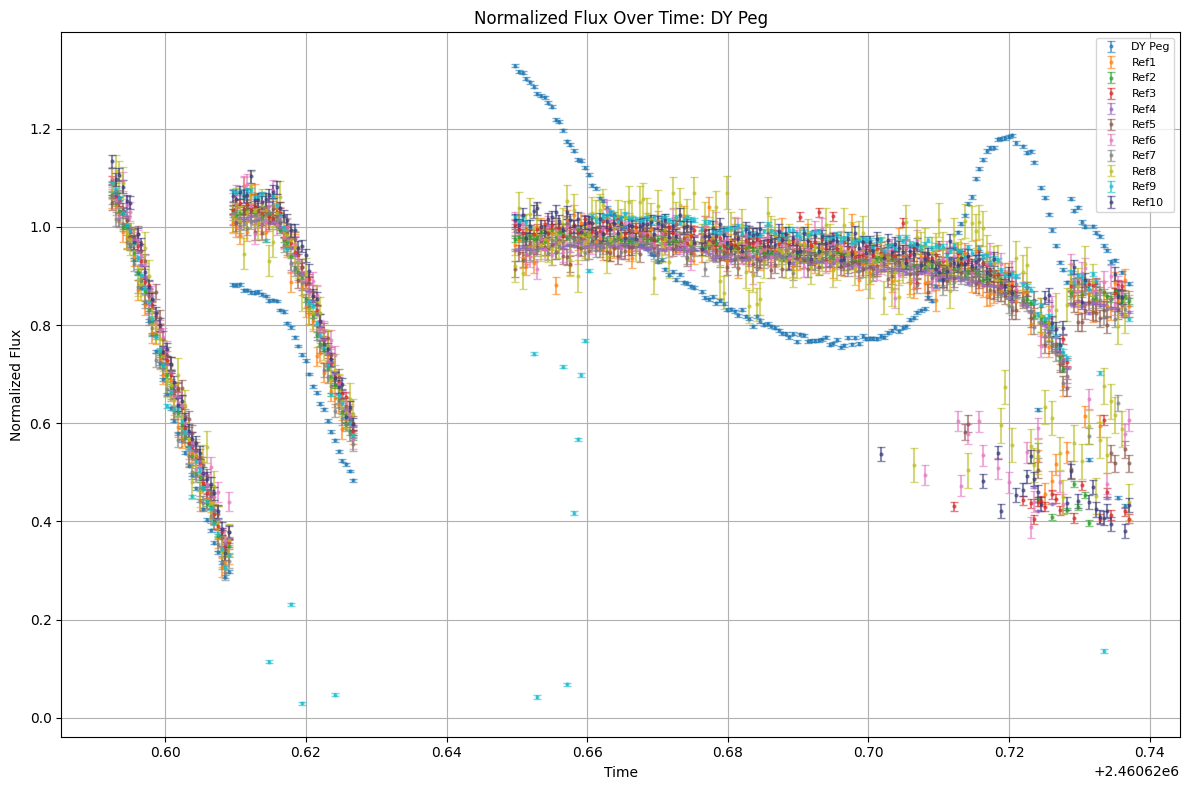

In [44]:
# Extract flux and fluxerr for each reference star
reference_fluxes_DY_Peg = [rescaled_cleaned_DY_Peg[target]["flux"] for target in [
    "DY Peg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]]
reference_flux_errors_DY_Peg = [rescaled_cleaned_DY_Peg[target]["fluxerr"] for target in [
    "DY Peg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]]
# Calculate the weighted means and errors for the reference fluxes
weighted_means_DY_Peg, weighted_errors_DY_Peg = calculate_weighted_mean_and_error(
    reference_fluxes_DY_Peg, reference_flux_errors_DY_Peg, cleaned_data=cleaned_light_curves_DY_Peg
)
# Calculate the weighted means, flux ratios, and their errors
r_i_DY_Peg, r_i_error_DY_Peg = calculate_r_and_error(reference_fluxes_DY_Peg, 
reference_flux_errors_DY_Peg, weighted_means_DY_Peg, weighted_errors_DY_Peg
)
# Now, run the normalize_flux_and_r function for DY_Peg
start_index = 75  # The start index of the stable region
region_length = 50  # The length of the region to read
stable_flux_threshold = 0.1  # Flux variation threshold for stability
min_stable_points = 10  # Minimum number of stable points
normed_flux, normed_flux_error, normed_r_i, normed_r_i_error = normalize_flux_and_r(
    reference_fluxes_DY_Peg, reference_flux_errors_DY_Peg, 
    specific_target=8,  # For Ref8
    r_i_list=r_i_DY_Peg,  
    r_i_error_list=r_i_error_DY_Peg, 
    start_index=start_index, 
    region_length=region_length, 
    stable_flux_threshold=stable_flux_threshold, 
    min_stable_points=min_stable_points
)
# Extract time for each reference star (same approach as flux)
time_points = [rescaled_cleaned_DY_Peg[target]["time"] for target in [
    "DY Peg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]]
# Now, plot the normalized flux for all targets
target = ["DY Peg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]
plot_normalized_flux(normed_flux, normed_flux_error, time_points, target)

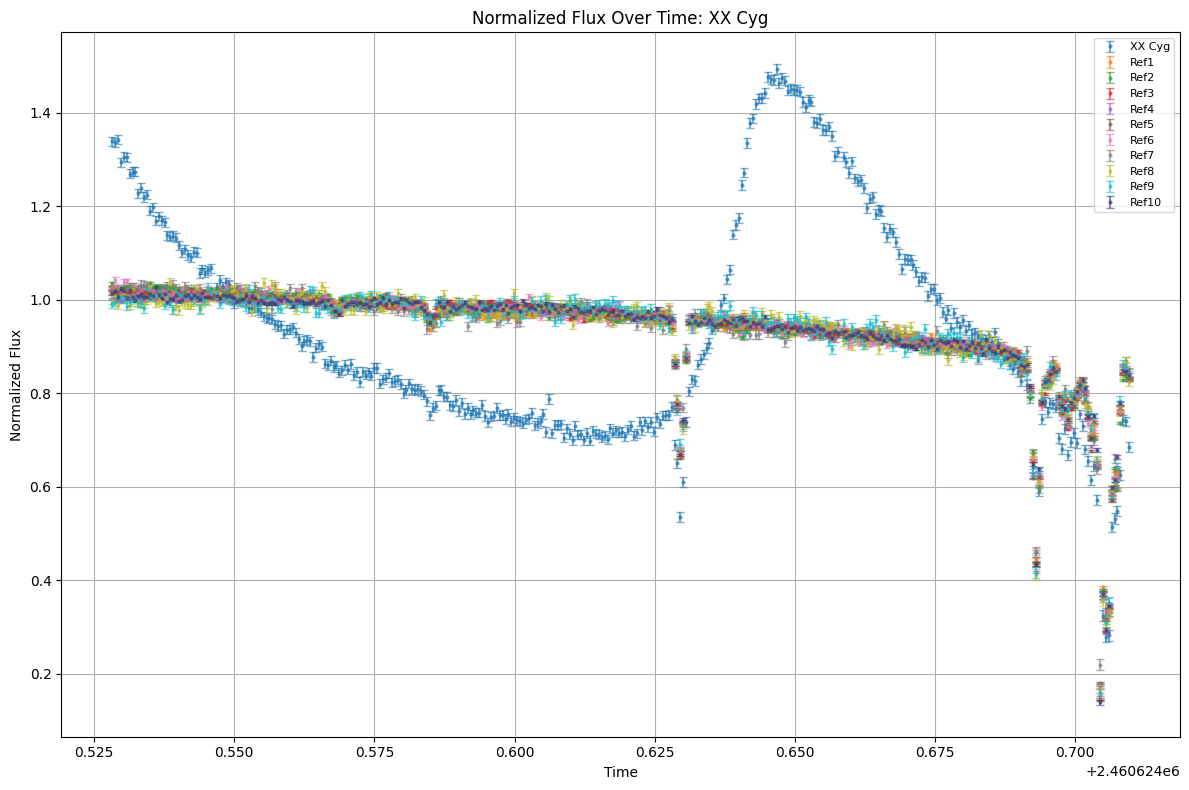

In [45]:
# Extract flux and fluxerr for each reference star for XX Cyg
reference_fluxes_XX_Cyg = [rescaled_cleaned_XX_Cyg[target]["flux"] for target in [
    "XX Cyg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]]
reference_flux_errors_XX_Cyg = [rescaled_cleaned_XX_Cyg[target]["fluxerr"] for target in [
    "XX Cyg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]]
# Calculate the weighted means and errors for the reference fluxes
weighted_means_XX_Cyg, weighted_errors_XX_Cyg = calculate_weighted_mean_and_error(
    reference_fluxes_XX_Cyg, reference_flux_errors_XX_Cyg, cleaned_data=cleaned_light_curves_XX_Cyg
)
# Calculate the weighted means, flux ratios, and their errors
r_i_XX_Cyg, r_i_error_XX_Cyg = calculate_r_and_error(reference_fluxes_XX_Cyg, 
reference_flux_errors_XX_Cyg, weighted_means_XX_Cyg, weighted_errors_XX_Cyg
)
# Now, run the normalize_flux_and_r function for DY_Peg
start_index = 0  # The start index of the stable region
region_length = 75  # The length of the region to read
stable_flux_threshold = 0.1  # Flux variation threshold for stability
min_stable_points = 10  # Minimum number of stable points
normed_flux_XX_Cyg, normed_flux_error_XX_Cyg, normed_r_i_XX_Cyg, normed_r_i_error_XX_Cyg = normalize_flux_and_r(
    reference_fluxes_XX_Cyg, reference_flux_errors_XX_Cyg, 
    specific_target=4,  # For Ref4
    r_i_list=r_i_XX_Cyg,  
    r_i_error_list=r_i_error_XX_Cyg, 
    start_index=start_index, 
    region_length=region_length, 
    stable_flux_threshold=stable_flux_threshold, 
    min_stable_points=min_stable_points
)
# Extract time for each reference star (same approach as flux)
time_points_XX_Cyg = [
    np.array(rescaled_cleaned_XX_Cyg[target]["time"]) for target in [
        "XX Cyg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"
    ]
]
# Now, plot the normalized flux for all targets
target = ["XX Cyg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]
plot_normalized_flux(normed_flux_XX_Cyg, normed_flux_error_XX_Cyg, time_points_XX_Cyg, target)

##### Section 4.5: Converting Flux (Counts) to V magnitude

In [46]:
def calculate_apparent_magnitude(
    normed_flux, normed_flux_error, 
    target_names, specific_target_name, 
    reference_star_name, reference_magnitude
):
    """
    Calculates the apparent magnitude of a specific target star using the reference star flux and magnitude.
    
    :param normed_flux: List of normalized flux arrays for all targets.
    :type normed_flux: list of np.ndarray
    :param normed_flux_error: List of normalized flux error arrays for all targets.
    :type normed_flux_error: list of np.ndarray
    :param target_names: List of target names corresponding to normed_flux and normed_flux_error.
    :type target_names: list of str
    :param specific_target_name: Name of the specific target star.
    :type specific_target_name: str
    :param reference_star_name: Name of the reference star.
    :type reference_star_name: str
    :param reference_magnitude: Known magnitude of the reference star.
    :type reference_magnitude: float
    :return: Apparent magnitudes and errors for the target star.
    :rtype: dict
    """
    # Find the indices for the specific target and reference star
    try:
        specific_target_index = target_names.index(specific_target_name)
        reference_star_index = target_names.index(reference_star_name)
    except ValueError as e:
        raise ValueError(f"Target or reference star not found in target_names list: {e}")
    
    # Retrieve normalized flux and error for the target and reference
    target_flux = normed_flux[specific_target_index]
    target_flux_error = normed_flux_error[specific_target_index]
    reference_flux = normed_flux[reference_star_index]
    reference_flux_error = normed_flux_error[reference_star_index]
    
    # Calculate the apparent magnitudes using the formula
    flux_ratio = target_flux / reference_flux
    apparent_magnitudes = reference_magnitude - 2.5 * np.log10(flux_ratio)
    
    # Propagate errors for magnitude calculation
    flux_ratio_error = np.abs(flux_ratio) * np.sqrt(
        (target_flux_error / target_flux)**2 + (reference_flux_error / reference_flux)**2
    )
    magnitude_errors = (2.5 / np.log(10)) * (flux_ratio_error / flux_ratio)
    
    # Return the calculated magnitudes and errors
    return {
        "apparent_magnitudes": apparent_magnitudes,
        "magnitude_errors": magnitude_errors,
    }

In [47]:
def plot_apparent_magnitude_vs_time(
    time_data, apparent_magnitudes, magnitude_errors, target_name
):
    """
    Plots the apparent magnitude of the target star versus time.
    
    :param time_data: Time points for the target star.
    :type time_data: np.ndarray or list
    :param apparent_magnitudes: Apparent magnitudes of the target star.
    :type apparent_magnitudes: np.ndarray
    :param magnitude_errors: Errors in the apparent magnitudes.
    :type magnitude_errors: np.ndarray
    :param target_name: Name of the target star.
    :type target_name: str
    :return: None
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        time_data,
        apparent_magnitudes,
        yerr=magnitude_errors,
        fmt='o',
        markersize = 2,
        color='blue',
        ecolor='gray',
        capsize=3,
        alpha = 0.6,
        label=f"{target_name}"
    )
    plt.title(f"Apparent Magnitude vs. Time for {target_name}", fontsize=14)
    plt.xlabel("Time [JD]", fontsize=12)
    plt.ylabel("App. V Magnitude", fontsize=12)
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

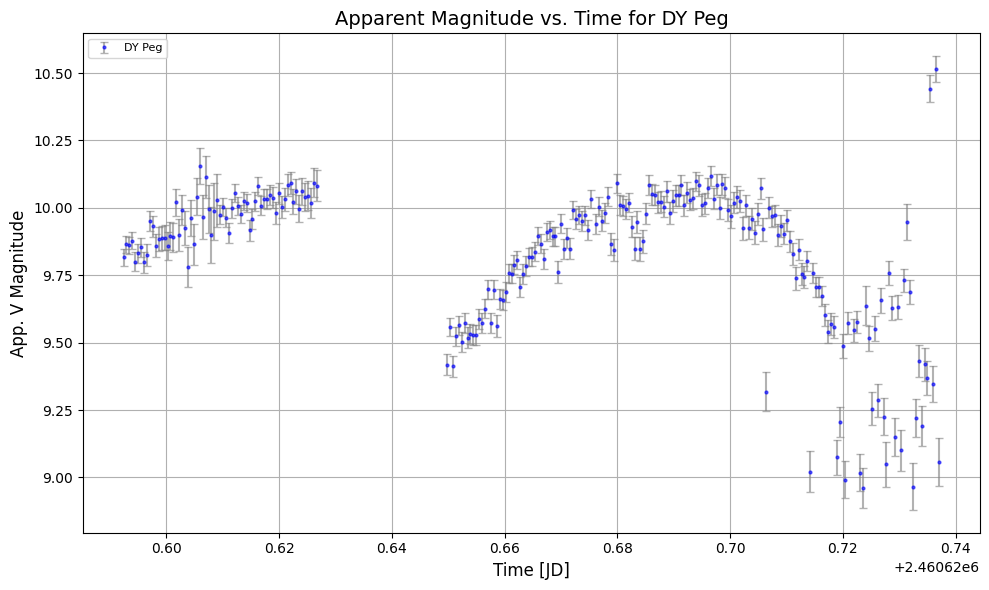

In [48]:
# List of target names
target_names = ["DY Peg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]
# Apparent magnitude of Ref8
reference_magnitude = 9.816
# Calculate apparent magnitudes and errors
magnitude_data = calculate_apparent_magnitude(
    normed_flux=normed_flux,
    normed_flux_error=normed_flux_error,
    target_names=target_names,
    specific_target_name="DY Peg",
    reference_star_name="Ref8",
    reference_magnitude=reference_magnitude
)
# Extract magnitudes and errors
apparent_magnitudes = magnitude_data["apparent_magnitudes"]
magnitude_errors = magnitude_data["magnitude_errors"]
# Extract time points for DY Peg
time_points = rescaled_cleaned_DY_Peg["DY Peg"]["time"]
# Plot the graph
plot_apparent_magnitude_vs_time(
    time_data=time_points,
    apparent_magnitudes=apparent_magnitudes,
    magnitude_errors=magnitude_errors,
    target_name="DY Peg"
)

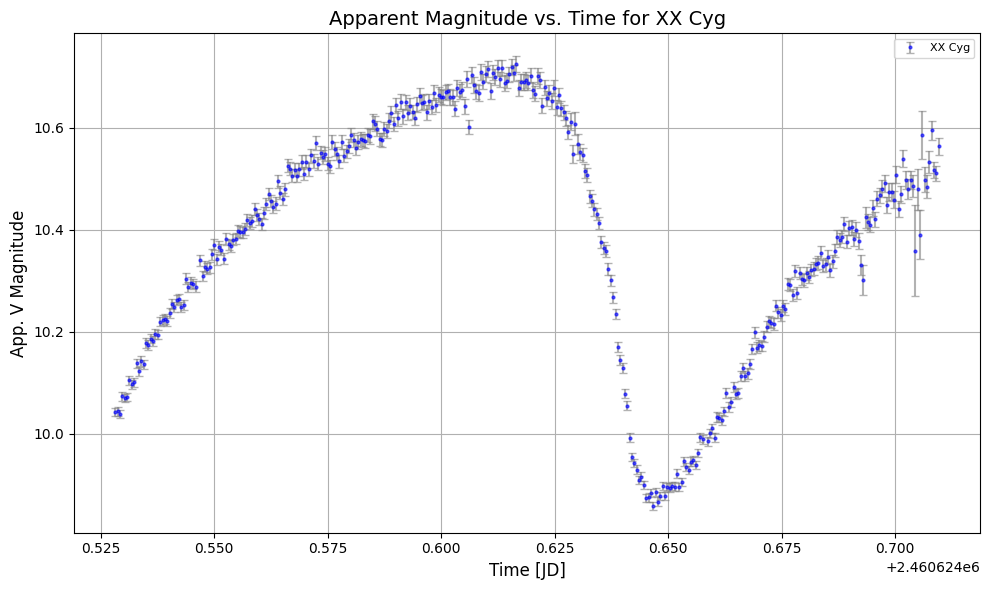

In [49]:
# List of target names
target_names_XX_Cyg = ["XX Cyg", "Ref1", "Ref2", "Ref3", "Ref4", "Ref5", "Ref6", "Ref7", "Ref8", "Ref9", "Ref10"]
# Apparent magnitude of Ref8
reference_magnitude = 10.358
# Calculate apparent magnitudes and errors
magnitude_data_XX_Cyg = calculate_apparent_magnitude(
    normed_flux=normed_flux_XX_Cyg,
    normed_flux_error=normed_flux_error_XX_Cyg,
    target_names=target_names_XX_Cyg,
    specific_target_name="XX Cyg",
    reference_star_name="Ref4",
    reference_magnitude=reference_magnitude
)
# Extract magnitudes and errors
apparent_magnitudes_XX_Cyg = magnitude_data_XX_Cyg["apparent_magnitudes"]
magnitude_errors_XX_Cyg = magnitude_data_XX_Cyg["magnitude_errors"]
# Extract time points for DY Peg
time_points_XX_Cyg = rescaled_cleaned_XX_Cyg["XX Cyg"]["time"]
# Plot the graph
plot_apparent_magnitude_vs_time(
    time_data=time_points_XX_Cyg,
    apparent_magnitudes=apparent_magnitudes_XX_Cyg,
    magnitude_errors=magnitude_errors_XX_Cyg,
    target_name="XX Cyg"
)

##### Section 5.1: Estimating Period of Light Curves

In [50]:
def convert_jd_to_hours(jd_list):
    """
    Converts Julian Date list to time differences in hours from the first point.
    :param jd_list: List of Julian Dates
    :return: List of time differences in hours from the first JD
    """
    time_in_hours = np.array([(jd - jd_list[0]) * 24 for jd in jd_list])
    return time_in_hours

In [51]:
def plot_phase_folded_light_curve_with_fit(time_data, apparent_magnitudes, magnitude_errors, target_name="Target"):
    """
    Plots a phase-folded light curve with error bars and the best-fit sinusoidal 
    model for the time and apparent magnitudes of the target, along with the 
    Lomb-Scargle periodogram.
    
    :param time_data: Time data (in Julian Date) for the target.
    :param apparent_magnitudes: Apparent magnitudes for the target.
    :param magnitude_errors: Errors in the apparent magnitudes.
    :param target_name: The name of the target object (default is "Target").
    :return: The best frequency, the model, and the frequency array.
    """
    # Convert time data from JD to hours
    time_data_in_hours = convert_jd_to_hours(time_data)
    
    # Perform Lomb-Scargle periodogram
    LS = LombScargle(time_data_in_hours, apparent_magnitudes, magnitude_errors)
    freqs = np.linspace(1/100, 1.0, 10000)  # Frequency grid (avoiding Nyquist limit)
    power = LS.power(freqs)
    
    # Find the best frequency and calculate the best period
    best_freq = freqs[np.argmax(power)]
    best_period = 1 / best_freq  # Convert best frequency to period (in hours)
    print(f'Best period: {best_period:.5f} hours')
    
    # Generate the best-fit model using the best frequency
    pred = LS.model(time_data_in_hours, best_freq)
    
    # Plot the phase-folded light curve and best-fit model
    phase = (time_data_in_hours % best_period) / best_period
    sorted_indices = np.argsort(phase)
    sorted_phase = phase[sorted_indices]
    sorted_magnitudes = apparent_magnitudes[sorted_indices]
    sorted_errors = magnitude_errors[sorted_indices]
    sorted_pred = pred[sorted_indices]  # Make sure to sort the model prediction

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot phase-folded light curve
    ax[0].errorbar(sorted_phase, sorted_magnitudes, yerr=sorted_errors, fmt='o', markersize=3, color='blue', ecolor='gray', capsize=3, alpha=0.6)
    ax[0].plot(sorted_phase, sorted_pred, color='red', linewidth=2, label="Best-fit Model")
    ax[0].set_title(f"Phase-Folded Light Curve for {target_name}")
    ax[0].set_xlabel("Phase")
    ax[0].set_ylabel("App. V Mag")
    ax[0].legend()
    ax[0].grid(True)
    
    # Plot Lomb-Scargle power spectrum
    ax[1].plot(freqs, power, color='green')
    ax[1].axvline(best_freq, color='red', linestyle='--', label=f"Best Frequency: {best_freq:.4f} 1/hrs")
    ax[1].set_title(f"Lomb-Scargle Power Spectrum for {target_name}")
    ax[1].set_xlabel("Frequency (1/hrs)")
    ax[1].set_ylabel("Power")
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return best_freq, sorted_pred, freqs

Best period: 1.81655 hours


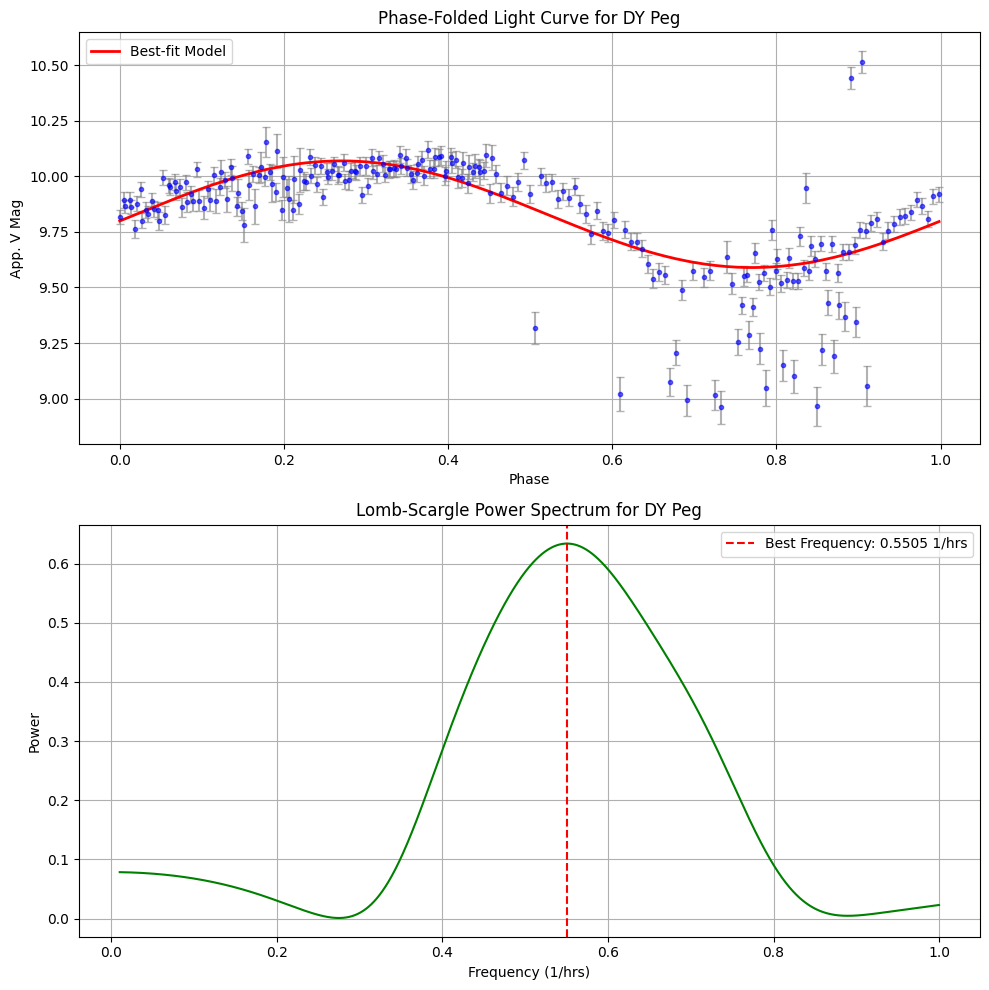

In [52]:
# Extract time points for DY Peg
time_points = rescaled_cleaned_DY_Peg["DY Peg"]["time"]

# Plot the phase-folded light curve with the best-fit sinusoidal model
best_frequency_DY_Peg, mode_DY_Peg, frequency_DY_Peg = plot_phase_folded_light_curve_with_fit(
    time_data=time_points, 
    apparent_magnitudes=apparent_magnitudes, 
    magnitude_errors=magnitude_errors,
    target_name="DY Peg"
)

Best period: 3.22478 hours


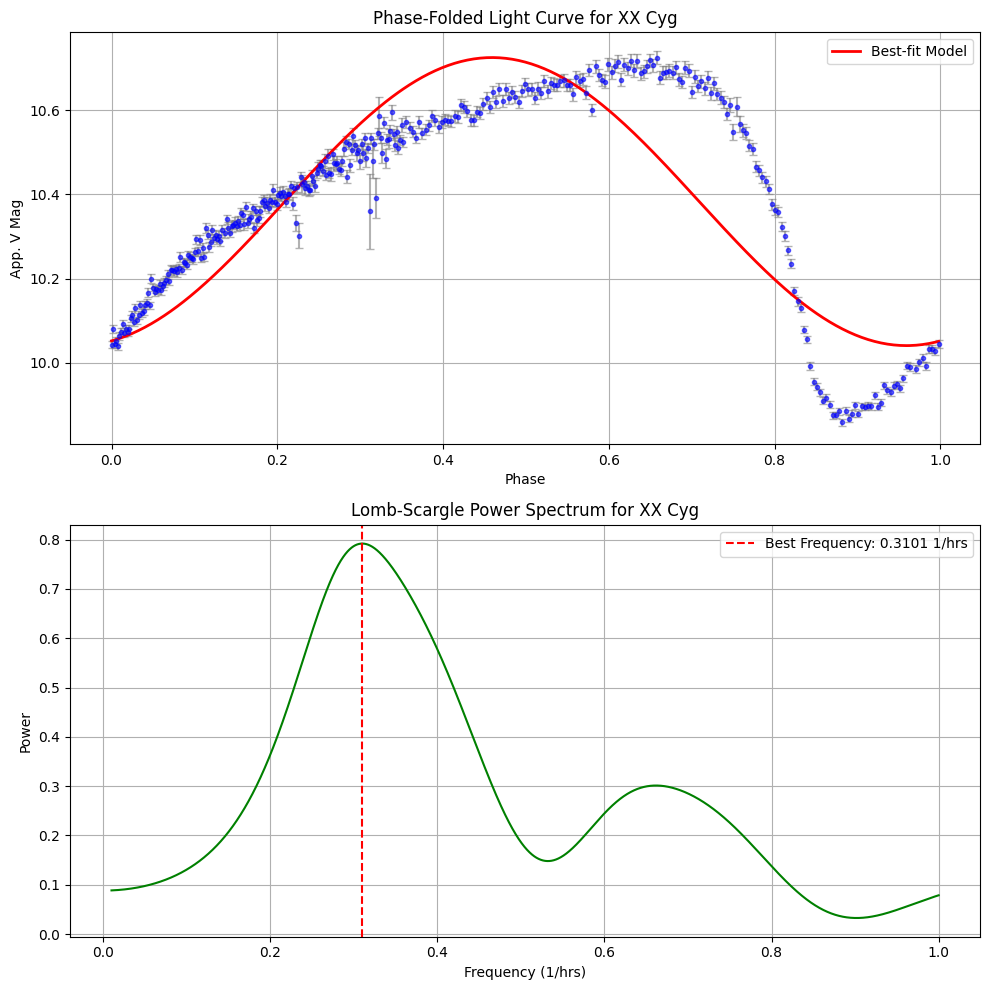

In [53]:
# Extract time points for XX Cyg
time_points_XX_Cyg = rescaled_cleaned_XX_Cyg["XX Cyg"]["time"]

# Plot the phase-folded light curve with the best-fit sinusoidal model
best_frequency_XX_Cyg, mode_XX_Cyg, frequency_XX_Cyg = plot_phase_folded_light_curve_with_fit(
    time_data=time_points_XX_Cyg, 
    apparent_magnitudes=apparent_magnitudes_XX_Cyg, 
    magnitude_errors=magnitude_errors_XX_Cyg,
    target_name="XX Cyg"
)

##### Section 5.2: Calculating Absolute Magnitudes

In [54]:
def calculate_absolute_magnitude_and_error(apparent_magnitudes, magnitude_errors, distance_pc, distance_error):
    """
    Calculates the absolute V magnitude (M_V) and its uncertainty using the 
    formula: M_V = m_v - 5 log10(d) + 5.

    :param apparent_magnitudes: Apparent magnitudes of the target star.
    :type apparent_magnitudes: list or numpy.ndarray
    :param magnitude_errors: Errors associated with the apparent magnitudes.
    :type magnitude_errors: list or numpy.ndarray
    :param distance_pc: Distance to the star in parsecs.
    :type distance_pc: float
    :param distance_error: Error in the distance to the star in parsecs.
    :type distance_error: float
    :return: Absolute V magnitude (M_V), its uncertainty (delta_M_V).
    :rtype: tuple (float, float)
    """
    # Calculate the average apparent magnitude (m_v)
    m_v_avg = np.mean(apparent_magnitudes)
    # Calculate the error on the average apparent magnitude (delta m_v)
    delta_m_v_avg = np.sqrt(np.sum(np.array(magnitude_errors) ** 2)) / len(apparent_magnitudes)
    # Calculate the absolute magnitude M_V
    M_V = m_v_avg - 5 * np.log10(distance_pc) + 5
    # Error propagation for M_V
    # ∂M_V/∂m_v = 1, ∂M_V/∂d = -5 / (d * ln(10))
    delta_M_V = np.sqrt(delta_m_v_avg**2 + (-5 * distance_error / (distance_pc * np.log(10)))**2)
    
    return m_v_avg, delta_m_v_avg, M_V, delta_M_V

In [55]:
distance_pc = 406.702  # Distance to DY Peg in parsecs
distance_error = 7.4763  # Error in the distance to DY Peg in parsecs
# Run the function with the provided data for DY Peg
m_v_avg_DY_Peg, delta_m_v_avg_DY_Peg, M_V_DY_Peg, delta_M_V_DY_Peg = calculate_absolute_magnitude_and_error(
    apparent_magnitudes, magnitude_errors, distance_pc, distance_error)
# Output the results
print(f"M_V: {M_V_DY_Peg:.5f}")
print(f"Error in M_V: {delta_M_V_DY_Peg:.5f}")
print(f"Average m_v (m_avg): {m_v_avg_DY_Peg:.5f}")
print(f"Error in m_avg (delta_m_avg): {delta_m_v_avg_DY_Peg:.5f}")

M_V: 1.77895
Error in M_V: 0.04003
Average m_v (m_avg): 9.82533
Error in m_avg (delta_m_avg): 0.00306


In [56]:
distance_pc_XX_Cyg = 1162.926  # Distance to XX Cyg in parsecs
distance_error_XX_Cyg = 23.1260  # Error in the distance to XX Cyg in parsecs
# Run the function with the provided data for XX Cyg
m_v_avg_XX_Cyg, delta_m_v_avg_XX_Cyg, M_V_XX_Cyg, delta_M_V_XX_Cyg = calculate_absolute_magnitude_and_error(
    apparent_magnitudes_XX_Cyg, magnitude_errors_XX_Cyg, distance_pc_XX_Cyg, distance_error_XX_Cyg)
# Output the results
print(f"M_V: {M_V_XX_Cyg:.5f}")
print(f"Error in M_V: {delta_M_V_XX_Cyg:.5f}")
print(f"Average m_v (m_avg): {m_v_avg_XX_Cyg:.5f}")
print(f"Error in m_avg (delta_m_avg): {delta_m_v_avg_XX_Cyg:.5f}")

M_V: 0.05736
Error in M_V: 0.04319
Average m_v (m_avg): 10.38512
Error in m_avg (delta_m_avg): 0.00077


##### Section 5.3: Period-Luminosity Plotting

In [58]:
def fit_period_luminosity_relation_with_bootstrap(best_frequency, M_V_values, M_V_errors, n_bootstrap=1000):
    """
    Fits the Period-Luminosity (P-L) relation M_V = a * log10(P) + b,
    where a and b are the slope and y-intercept, respectively.
    
    This version uses bootstrapping to estimate the uncertainties on the fit parameters.

    :param best_frequency: List or numpy array of best frequencies (in 1/hour).
    :type best_frequency: list or numpy.ndarray
    :param M_V_values: List or numpy array of absolute magnitudes M_V.
    :type M_V_values: list or numpy.ndarray
    :param M_V_errors: List or numpy array of errors associated with M_V.
    :type M_V_errors: list or numpy.ndarray
    :param n_bootstrap: Number of bootstrap samples to generate (default 1000).
    :type n_bootstrap: int
    :return: The fitted parameters (a, b) and their uncertainties (a_error, b_error).
    :rtype: tuple (float, float, float, float)
    """
    
    # Convert frequencies to periods in days
    periods_in_days = (1 / np.array(best_frequency)) / 24  # Period in days (from hours)
    
    # Define the linear model for the Period-Luminosity relation
    def pl_relation(P, a, b):
        return a * np.log10(P) + b
    
    # Perform the curve fitting to find a and b
    params, _ = curve_fit(pl_relation, periods_in_days, M_V_values, sigma=M_V_errors)
    a_fit, b_fit = params
    
    # Bootstrapping to estimate the uncertainty of a and b
    bootstrap_a = []
    bootstrap_b = []
    for _ in range(n_bootstrap):
        # Resample data with replacement
        indices = np.random.choice(len(best_frequency), size=len(best_frequency), replace=True)
        resampled_periods = np.array(periods_in_days)[indices]
        resampled_M_V = np.array(M_V_values)[indices]
        resampled_errors = np.array(M_V_errors)[indices]
        # Fit the model to the resampled data
        resampled_params, _ = curve_fit(pl_relation, resampled_periods, resampled_M_V, sigma=resampled_errors)
        # Store the fitted parameters
        bootstrap_a.append(resampled_params[0])
        bootstrap_b.append(resampled_params[1])
    
    # Calculate the standard deviation of the bootstrap results as the uncertainties
    a_error = np.std(bootstrap_a)
    b_error = np.std(bootstrap_b)
    
    # Generate x values for the fitted line (log(period) values)
    x_values = np.linspace(min(periods_in_days), max(periods_in_days), 100)
    y_values = pl_relation(x_values, a_fit, b_fit)
    
    # Plotting the results
    plt.errorbar(np.log10(periods_in_days), M_V_values, yerr=M_V_errors, fmt='o', label='Data', color='blue')
    plt.plot(np.log10(x_values), y_values, label=f'Fit: a = {a_fit:.3f} ± {a_error:.3f}, b = {b_fit:.3f} ± {b_error:.3f}', color='red')

    # Adding the literature curve
    # M_V = -1.640 - 3.389 * log(P)
    a_lit = -3.389
    b_lit = -1.640
    lit_y_values = a_lit * np.log10(x_values) + b_lit
    # Error in the literature curve: σ = 0.104, ±0.110 ±0.090
    sigma_lit = 0.104
    error_high = lit_y_values + sigma_lit
    error_low = lit_y_values - sigma_lit
    
    # Plot the literature curve with shaded error regions
    plt.plot(np.log10(x_values), lit_y_values, label=f'Cohen & Sarajedini (2011): a = {a_lit}, b = {b_lit}', color='green', linestyle='--')
    plt.fill_between(np.log10(x_values), error_low, error_high, color='green', alpha=0.3)

    # Labels and title
    plt.xlabel('log(P) [days]')
    plt.ylabel('M_V')
    plt.title('Period-Luminosity Relationship')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

    # Output the fit parameters and errors
    print(f"Best Fit: a = {a_fit:.3f} ± {a_error:.3f}, b = {b_fit:.3f} ± {b_error:.3f}")

    return a_fit, b_fit, a_error, b_error

C:\Users\misha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


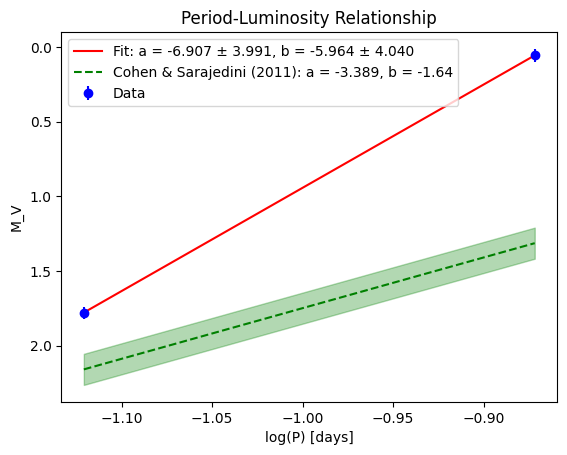

Best Fit: a = -6.907 ± 3.991, b = -5.964 ± 4.040


In [59]:
# Create arrays for both DY Peg and XX Cyg
best_frequencies = [best_frequency_DY_Peg, best_frequency_XX_Cyg]  # Frequencies in 1/hour
M_V_values = [M_V_DY_Peg, M_V_XX_Cyg]  # Corresponding M_V values
delta_M_V_values = [delta_M_V_DY_Peg, delta_M_V_XX_Cyg]  # Corresponding errors in M_V

# Call the fitting function with the data for both DY Peg and XX Cyg
a_fit, b_fit, a_error, b_error = fit_period_luminosity_relation_with_bootstrap(
    best_frequencies,  # Best frequencies for both stars
    M_V_values,        # M_V values for both stars
    delta_M_V_values,   # Errors in M_V for both stars
    n_bootstrap=100000
)